- df_pivot_init : "게임"의 각 분야별 점수 집계 df. 이걸로 게임 추천
- merged_df : "리뷰" df. 감성분석 포함. 해당 게임의 클러스터 포함.
- user_review_chain : "유저"별 리뷰 chain. key : 유저 id / value : [cluster_history,appid_history,voted_history, player_history, playtime_history, voted_history, score_history]
  - cluster_history:['cluster']
  - appid_history:['appid']
  - voted_history:['voted_up']
  - player_history:[['author_num_games_owned'],['author_num_reviews']]
  - playtime_history:[['author_playtime_forever'],['author_playtime_at_review']]
  - voted_history:['review_category']
  - score_history:[['gameplay_label'],['market_label'],['social_label'],['narrative_label'],['graphics_label'],['technical_label'],['value_label'],['audio_label']]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import numpy as np
import ast
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import display
import itertools
from collections import Counter
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# 게임 추천 모델 : 최종 data table 제작
- good_memory, bad memory, review로 유저의 게임 이력 분석


In [ ]:
df_pivot_init = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/game_with_cluster.csv")
df_with_cluster = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/df_with_cluster.csv")

In [ ]:
file_path = '/content/drive/MyDrive/DA-STEAM 게임시장분석/data/user_review_chain.json'

# Load the JSON file
with open(file_path, 'r') as file:
    user_review_chain = json.load(file)

In [ ]:
# 빈 리스트 생성
data = []

# user_review_chain 딕셔너리 순회
for user_id, review_chain in tqdm(user_review_chain.items()):
    idx = 0  # 이력 인덱스 초기화
    num = len(review_chain[0])

    # 각 이력에 대해 정보 추출
    for i in range(num):

        cluster = review_chain[0][i]
        appid = review_chain[1][i]
        voted = review_chain[2][i]
        num_games_owned = review_chain[3][i][0]
        num_reviews = review_chain[3][i][1]
        playtime_forever = review_chain[4][i][0]
        playtime_at_review = review_chain[4][i][1]
        review_category = review_chain[5][i]
        score = review_chain[6][i]
        
        # 행을 리스트로 생성하고 데이터에 추가
        row = [
            user_id,
            idx,
            cluster,
            appid,
            voted,
            num_games_owned,
            num_reviews,
            playtime_forever,
            playtime_at_review,
            review_category,
            score
        ]
        data.append(row)
        
        idx += 1  # 이력 인덱스 증가

100%|██████████| 2521105/2521105 [00:14<00:00, 177521.83it/s]


In [ ]:
# DataFrame 생성
columns = [
    'user',
    'idx',
    'cluster',
    'appid',
    'voted',
    'num_games_owned',
    'num_reviews',
    'playtime_forever',
    'playtime_at_review',
    'review_category',
    'score'
]

df = pd.DataFrame(data, columns=columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843598 entries, 0 to 4843597
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user                object 
 1   idx                 int64  
 2   cluster             int64  
 3   appid               int64  
 4   voted               bool   
 5   num_games_owned     int64  
 6   num_reviews         int64  
 7   playtime_forever    int64  
 8   playtime_at_review  float64
 9   review_category     object 
 10  score               object 
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 374.2+ MB


In [ ]:
df.columns

Index(['user', 'idx', 'cluster', 'appid', 'voted', 'num_games_owned',
       'num_reviews', 'playtime_forever', 'playtime_at_review',
       'review_category', 'score'],
      dtype='object')

In [ ]:
# "memory" 열을 추가하기 위한 빈 리스트 생성
total_good_memory = []
total_bad_memory = []

# 사용자별로 그룹화하여 순회
for user_id, group in tqdm(df.groupby('user')):
    # 각 cluster별로 플레이타임을 저장할 리스트 초기화
    good_memory = [[0] for _ in range(8)]
    bad_memory = [[0] for _ in range(8)]

    # 각 사용자 그룹 내에서 행 순회
    for i, row in group.iterrows():
      total_good_memory.append([[sum(i)] for i in good_memory])
      total_bad_memory.append([[sum(i)] for i in bad_memory])

      # 현재 행의 cluster별 플레이타임을 업데이트  
      if row['voted'] == True:
        good_memory[row['cluster']].append(row['playtime_at_review'])
      if row['voted'] == False:
        bad_memory[row['cluster']].append(row['playtime_at_review'])

100%|██████████| 2521105/2521105 [13:38<00:00, 3080.27it/s]


In [ ]:
len(total_good_memory)

4843598

In [ ]:
total_good_memory_clean = []
for i in tqdm(total_good_memory):
  add = []
  for j in i:
    add.append(int(j[0]))
  total_good_memory_clean.append(add)

100%|██████████| 4843598/4843598 [00:32<00:00, 147656.99it/s]


In [ ]:
total_bad_memory_clean = []
for i in tqdm(total_bad_memory):
  add = []
  for j in i:
    add.append(int(j[0]))
  total_bad_memory_clean.append(add)

100%|██████████| 4843598/4843598 [00:13<00:00, 369813.45it/s]


In [ ]:
# "memory" 열을 DataFrame에 추가
df['good_memory'] = total_good_memory_clean
df['bad_memory'] = total_bad_memory_clean

In [ ]:
df_merged = df.merge(df_pivot_init, on='appid')
df_merged.drop(['cluster_y'], axis = 1, inplace = True)
df_merged.rename(columns = {'cluster_x' : 'cluster'}, inplace = True)

In [ ]:
df_model = df_merged
df_model = df_model[df_model['user'] != 76561200000000000] # 익명 유저들 제거
len(df_model)

4798364

In [ ]:
# 데이터프레임에서 user 열을 기준으로 한 개의 값만 가지고 있는 행 삭제
df_model_filtered = df_model.groupby('user').filter(lambda x: len(x) > 1)
len(df_model_filtered)

3106958

In [ ]:
df_model_filtered['good_memory'] = df_model_filtered['good_memory'].apply(ast.literal_eval)
df_model_filtered['bad_memory'] = df_model_filtered['bad_memory'].apply(ast.literal_eval)

In [ ]:
# x값 만들기

# 새로운 열을 저장할 빈 리스트 생성
new_columns = ['cluster_1_good', 'cluster_2_good', 'cluster_3_good', 'cluster_4_good', 'cluster_5_good', 'cluster_6_good', 'cluster_7_good', 'cluster_8_good']
new_data = [[] for _ in range(len(new_columns))]

In [ ]:
# 기존 열의 값을 쪼개어 새로운 열에 저장
for i, row in tqdm(df_model_filtered.iterrows(), total=len(df_model_filtered)):
    values = row['good_memory']
    for j, value in enumerate(values):
        new_data[j].append(value)

100%|██████████| 3106958/3106958 [02:05<00:00, 24819.84it/s]


In [ ]:
# 새로운 열을 DataFrame에 추가
for i in tqdm(range(len(new_columns))):
    df_model_filtered[new_columns[i]] = new_data[i]

100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


In [ ]:
# 새로운 열을 저장할 빈 리스트 생성
new_columns = ['cluster_1_bad', 'cluster_2_bad', 'cluster_3_bad', 'cluster_4_bad', 'cluster_5_bad', 'cluster_6_bad', 'cluster_7_bad', 'cluster_8_bad']
new_data = [[] for _ in range(len(new_columns))]

# 기존 열의 값을 쪼개어 새로운 열에 저장
for i, row in tqdm(df_model_filtered.iterrows(), total=len(df_model_filtered)):
    values = row['bad_memory']
    for j, value in enumerate(values):
        new_data[j].append(value)

# 새로운 열을 DataFrame에 추가
for i in tqdm(range(len(new_columns))):
    df_model_filtered[new_columns[i]] = new_data[i]

100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


In [ ]:
df_model_filtered.sort_values(['user',	'idx'], ascending = [True, True],inplace = True)
df_model_filtered.reset_index(drop=True, inplace = True)

recommendable_games_list = []

grouped_df = df_model_filtered.groupby('user')

for user, group in tqdm(grouped_df):

    ttmp = []
    for i, row in group.iterrows():
      if row['voted'] == True:
        ttmp.append(row['appid'])
      else:
        ttmp.append(np.nan)

    ttmp2 = pd.DataFrame(ttmp, columns=['Values'])

    # 보간(interpolate)을 사용하여 결측치 채우기
    ttmp2['Values'].interpolate(method='bfill', inplace=True)

    ttmp_filled = ttmp2['Values'].tolist()[1:]

    # 맨 마지막에 np.nan 추가
    ttmp_filled.append(np.nan)
    
    recommendable_games_list.append(ttmp_filled)

100%|██████████| 829698/829698 [12:14<00:00, 1128.86it/s]


In [ ]:
flatten_recommended_games = [game for games in recommendable_games_list for game in games]

In [ ]:
print(len(df_model_filtered))
print(len(flatten_recommended_games))

3106958
3106958


In [ ]:
df_model_filtered['recommandable_game'] = flatten_recommended_games
df_user_lifecyle = df_model_filtered.dropna()

df_user_lifecyle['recommandable_game'] = df_user_lifecyle['recommandable_game'].astype(int)
df_user_lifecyle = df_user_lifecyle.merge(df_pivot_init, left_on='recommandable_game', right_on = 'appid', how='left')

In [ ]:
df_user_lifecyle.columns

Index(['user', 'idx', 'cluster_x', 'appid_x', 'voted', 'num_games_owned',
       'num_reviews', 'playtime_forever', 'playtime_at_review',
       'review_category', 'score', 'good_memory', 'bad_memory', 'gameplay_x',
       'market_x', 'social_x', 'narrative_x', 'graphics_x', 'technical_x',
       'value_x', 'audio_x', 'total_x', 'gameplay_count_x', 'market_count_x',
       'social_count_x', 'narrative_count_x', 'graphics_count_x',
       'technical_count_x', 'value_count_x', 'audio_count_x', 'cluster_1_good',
       'cluster_2_good', 'cluster_3_good', 'cluster_4_good', 'cluster_5_good',
       'cluster_6_good', 'cluster_7_good', 'cluster_8_good', 'cluster_1_bad',
       'cluster_2_bad', 'cluster_3_bad', 'cluster_4_bad', 'cluster_5_bad',
       'cluster_6_bad', 'cluster_7_bad', 'cluster_8_bad', 'recommandable_game',
       'appid_y', 'gameplay_y', 'market_y', 'social_y', 'narrative_y',
       'graphics_y', 'technical_y', 'value_y', 'audio_y', 'total_y',
       'gameplay_count_y', 'marke

In [ ]:
df_user_lifecyle.to_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/df_user_lifecyle.csv", index = False)

# EDA

## category의 이동 분석 : step 1, 2

In [ ]:
df = df_user_lifecyle

# review category별 score string -> list
score_list = []

for i in range(len(df)):
    string = df['score'][i]
    string = string.replace('[','').replace(']','').replace(' ','')
    lst = string.split(',')
    
    for j in range(len(lst)):
        if lst[j] != 'nan':
            lst[j] = float(lst[j])
    
    score_list.append(lst)

In [ ]:
# 1단계 기준으로 review chain 보기 (A-B)
# x에서 x+1 군집으로 이동한 유저들이 평가한 ith category = one_step[x][x+1][i]
one_step = [[[0]*8 for _ in range(8)] for _ in range(8)]
count = [[[0]*8 for _ in range(8)] for _ in range(8)]

for i in range(len(df)-1):
    if df['user'][i] == df['user'][i+1]:
        cur_cluster = df['cluster_x'][i]
        nx_cluster = df['cluster_x'][i+1]
        
        for j in range(8):
            #review를 한 category에 대해서만 추출
            if score_list[i][j] != "nan":    
                # 긍정 2, 중립 1, 부정 0이기 때문에 score-1을 총합
                one_step[cur_cluster][nx_cluster][j]+=score_list[i][j]-1
                count[cur_cluster][nx_cluster][j]+=1
                
for cur_cluster in range(8):
    for nx_cluster in range(8):
        for category in range(8):
            # count를 나눠줘서 게임별 category의 평균 평가 score 구하기
            one_step[cur_cluster][nx_cluster][category]/=count[cur_cluster][nx_cluster][category]

In [ ]:
# 2단계 기준으로 review chain 보기(A-B-C)
# x에서 x+1이후에 x+2로 이동한 유저들이 평가한 ith category = two_step[x][x+1][x+2]
two_step = [[[[0]*8 for _ in range(8)] for _ in range(8)] for _ in range(8)]
count = [[[[0]*8 for _ in range(8)] for _ in range(8)] for _ in range(8)]

for i in range(len(df)-2):
    if df['user'][i] == df['user'][i+1] == df['user'][i+2]:
        first_cluster = df['cluster_x'][i]
        second_cluster = df['cluster_x'][i+1]
        third_cluster = df['cluster_x'][i+2]
        
        for j in range(8):
            # review를 한 category에 대해서만 추출
            if score_list[i][j] != "nan":
                # 긍정 2, 중립 1 부정 0이기 때문에 score-1을 총합
                two_step[first_cluster][second_cluster][third_cluster][j]+=score_list[i][j]-1
                count[first_cluster][second_cluster][third_cluster][j]+=1
    
for first_cluster in range(8):
    for second_cluster in range(8):
        for third_cluster in range(8):
            for category in range(8):
                # count를 나눠줘서 게임별 category의 평균 평가 score 구하기
                two_step[first_cluster][second_cluster][third_cluster][category]/=count[first_cluster][second_cluster][third_cluster][category]

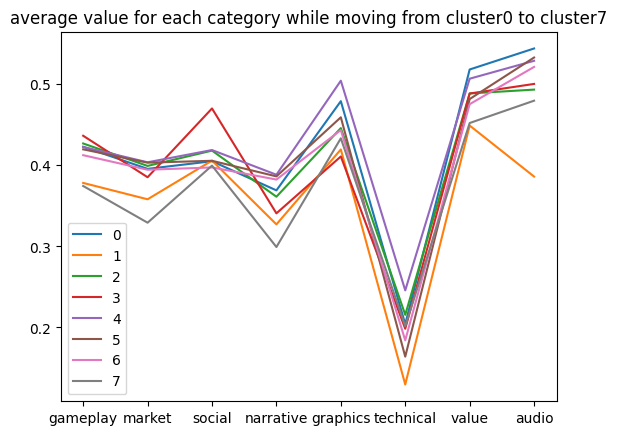

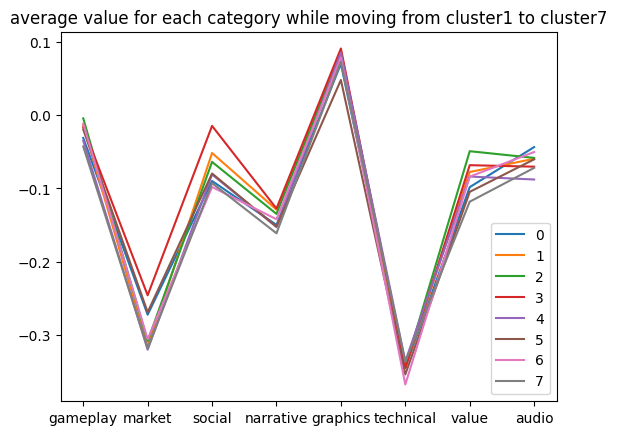

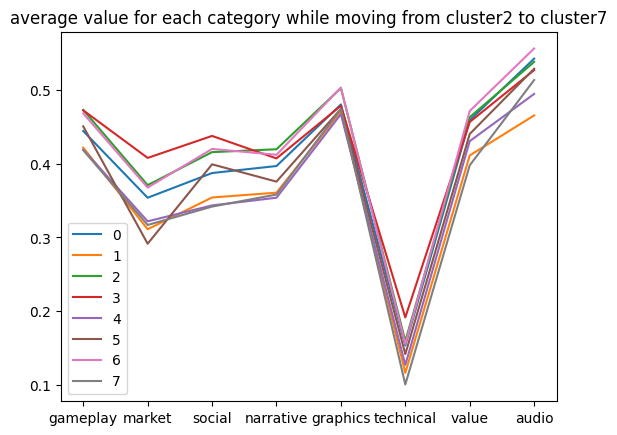

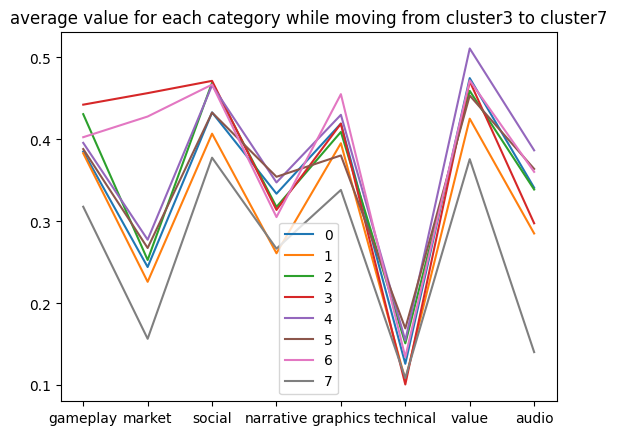

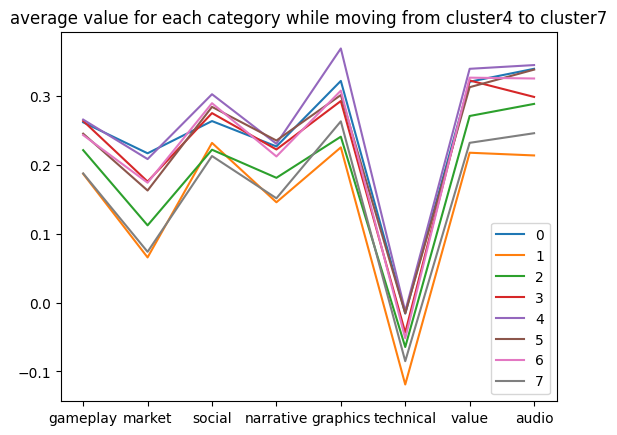

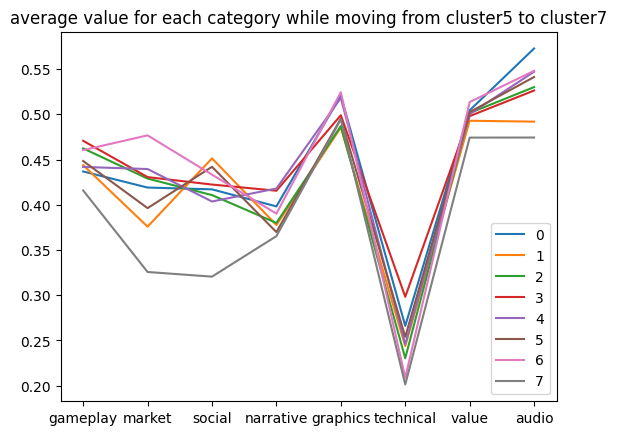

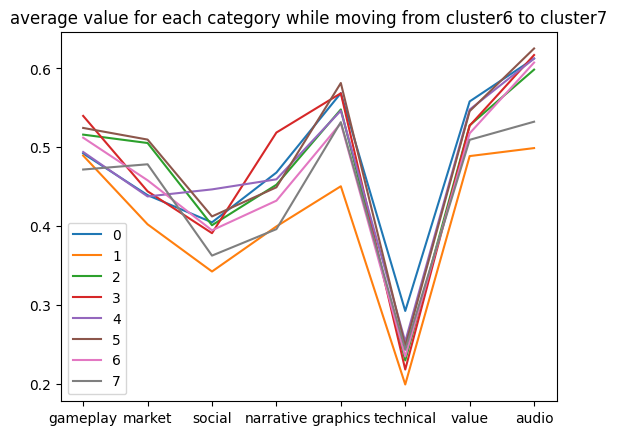

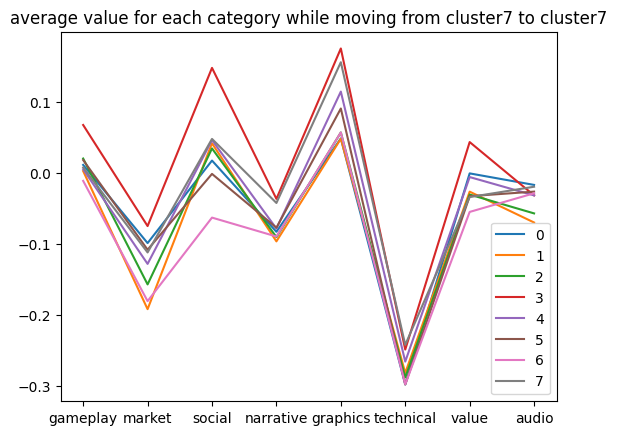

In [ ]:
#one step부터 보기
import matplotlib.pyplot as plt
for i in range(8):
    for j in range(8):
        plt.plot(['gameplay','market','social','narrative','graphics','technical','value','audio'], one_step[i][j], label = j)
    plt.legend()
    plt.title(f"average value for each category while moving from cluster{i} to next cluster")
    plt.show()

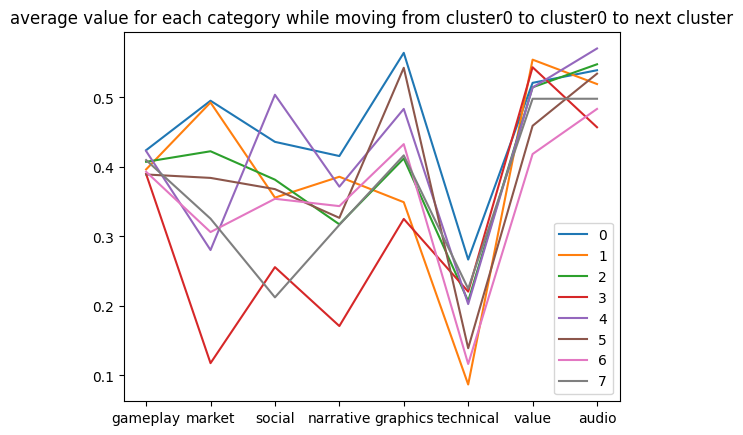

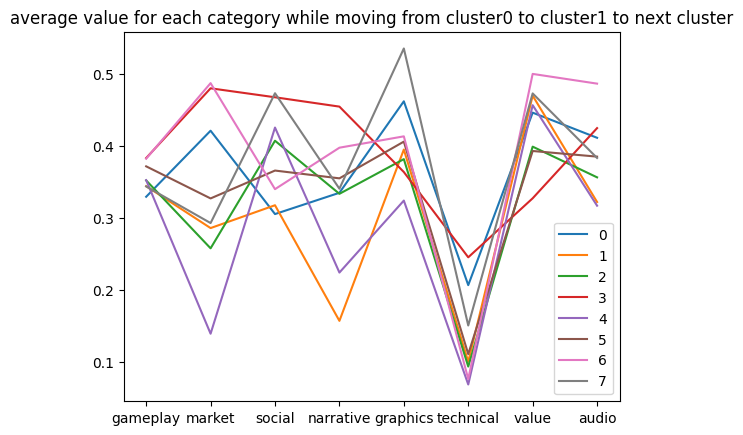

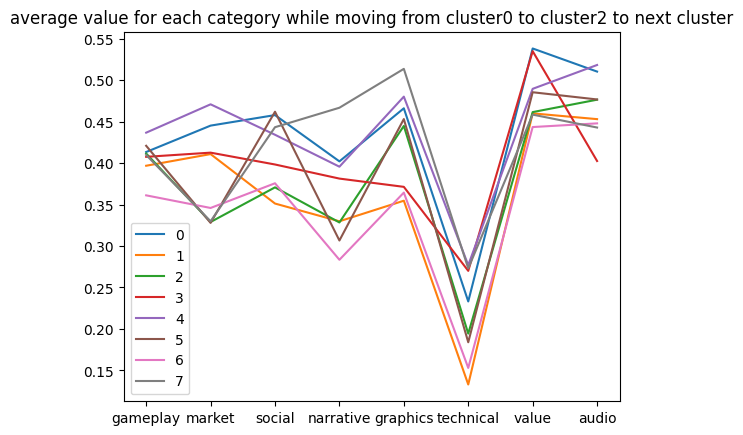

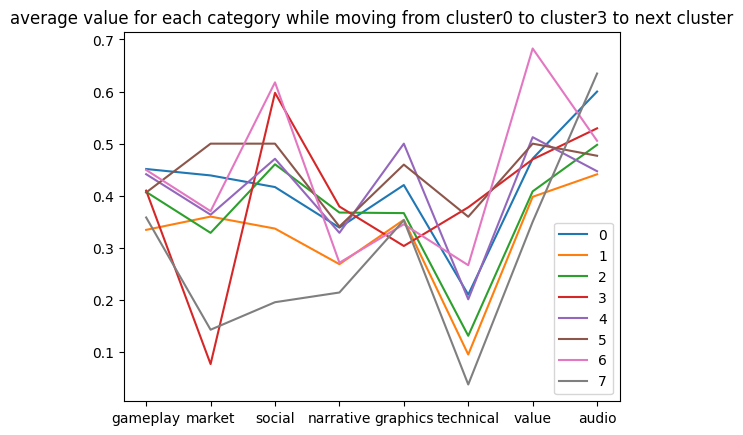

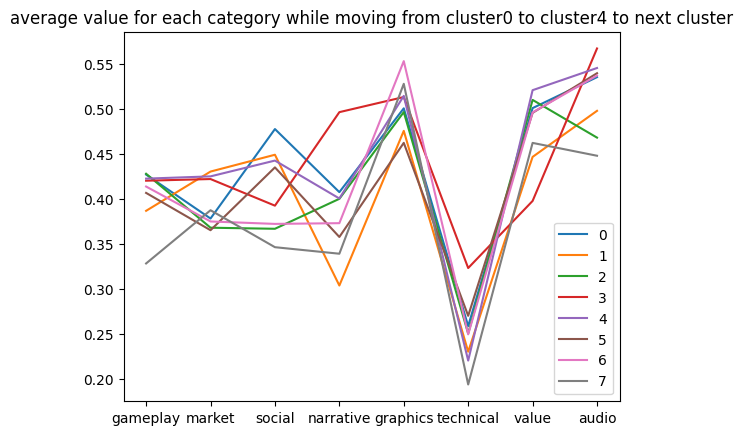

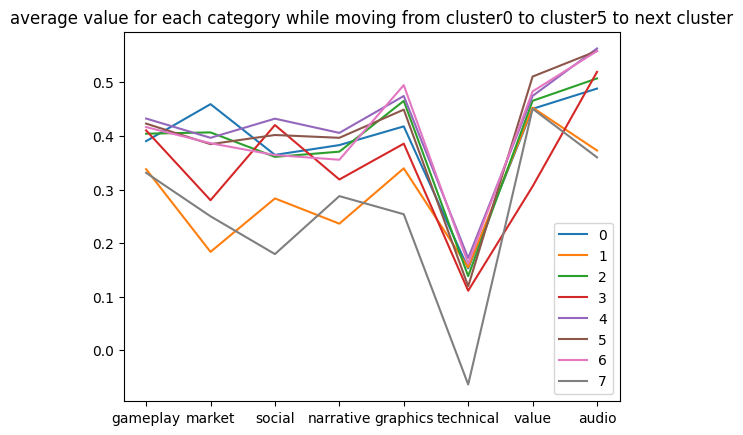

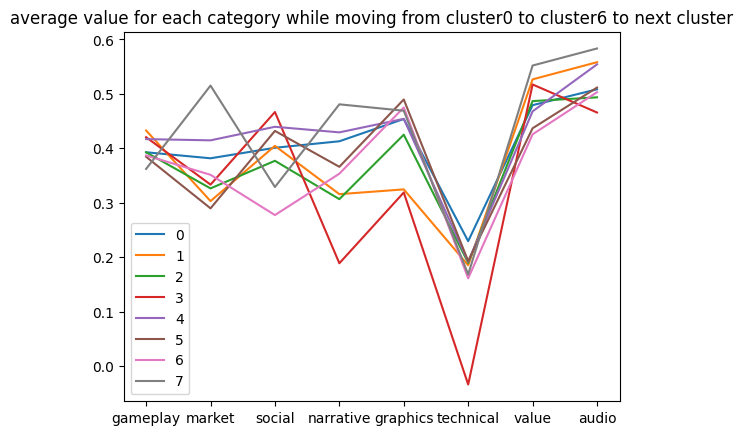

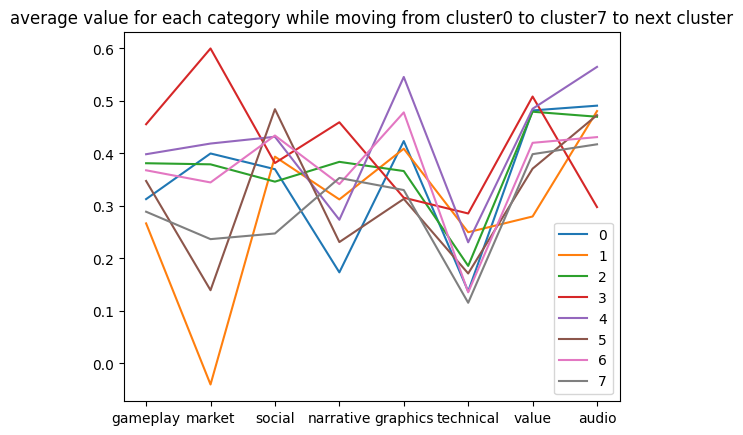

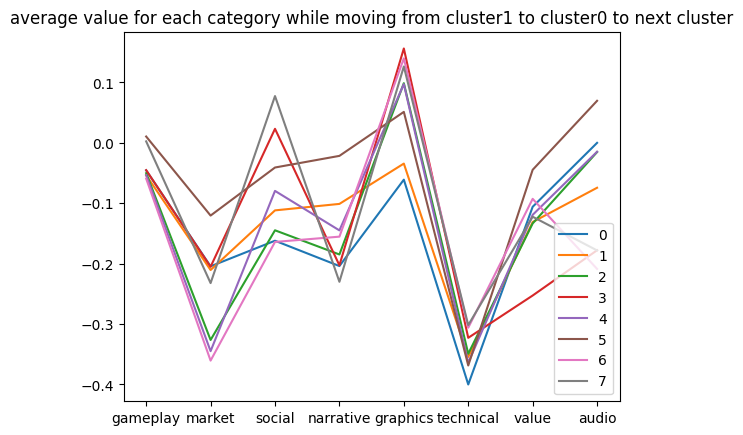

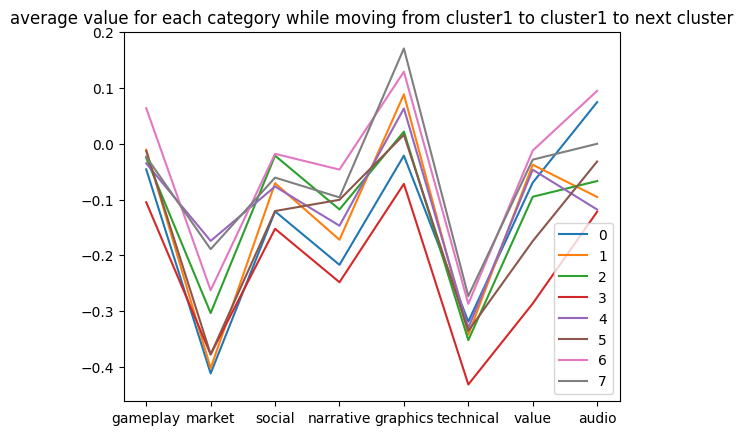

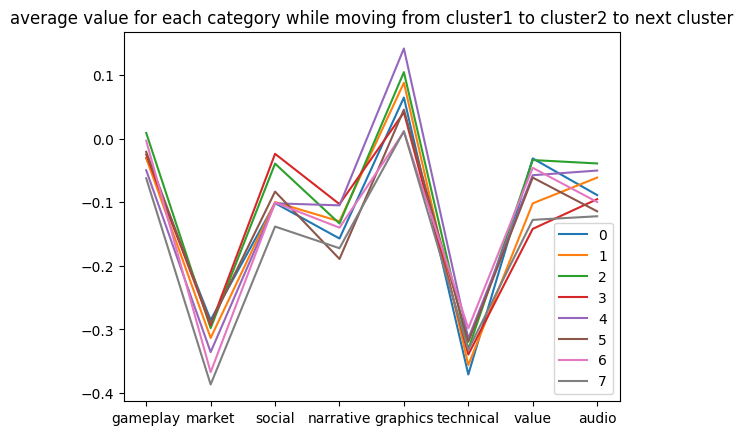

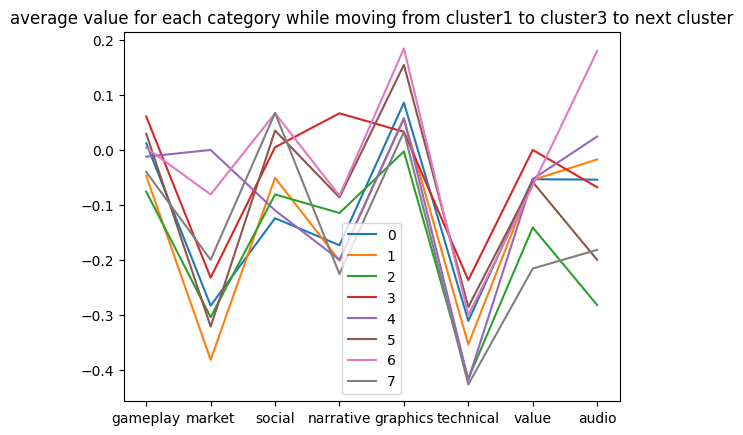

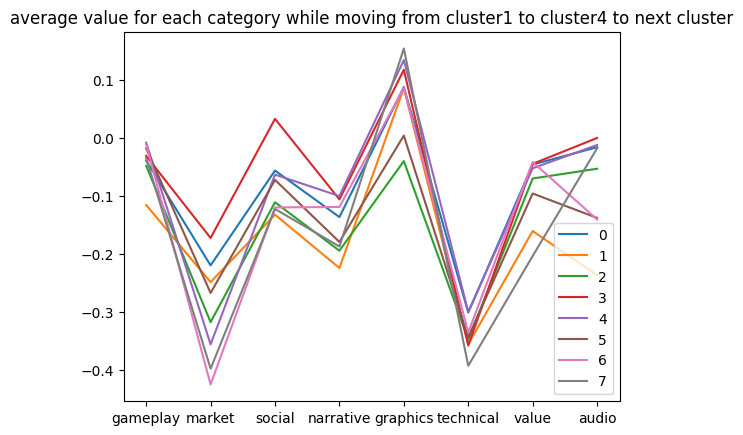

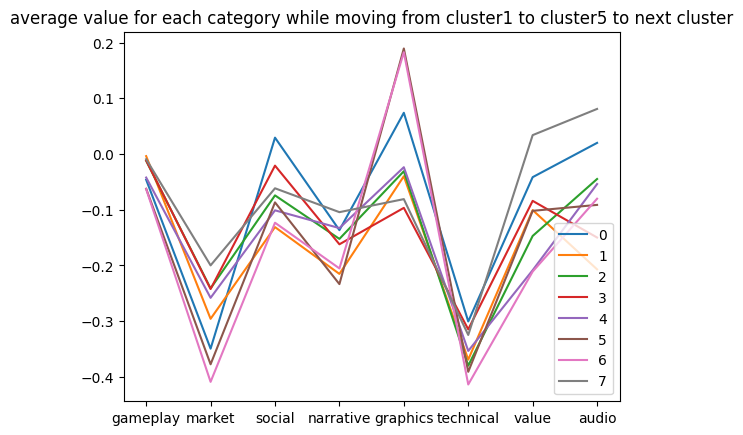

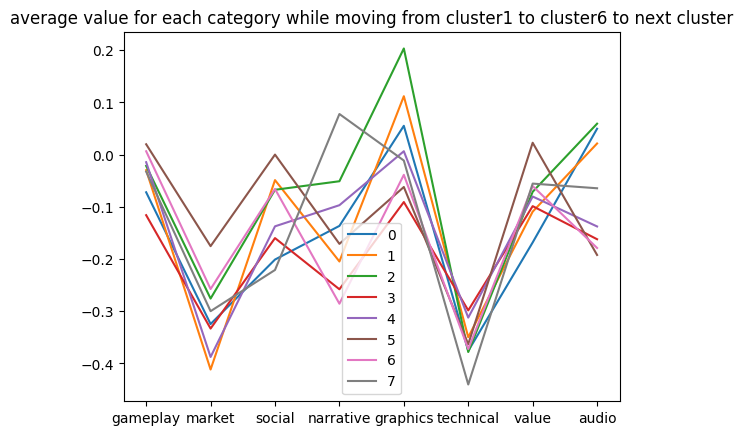

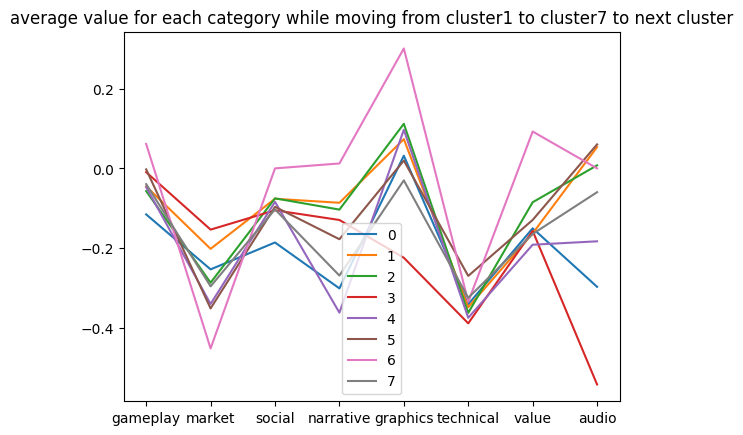

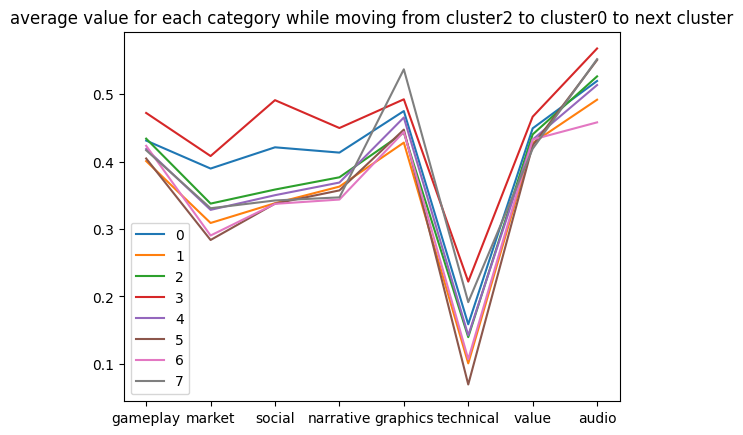

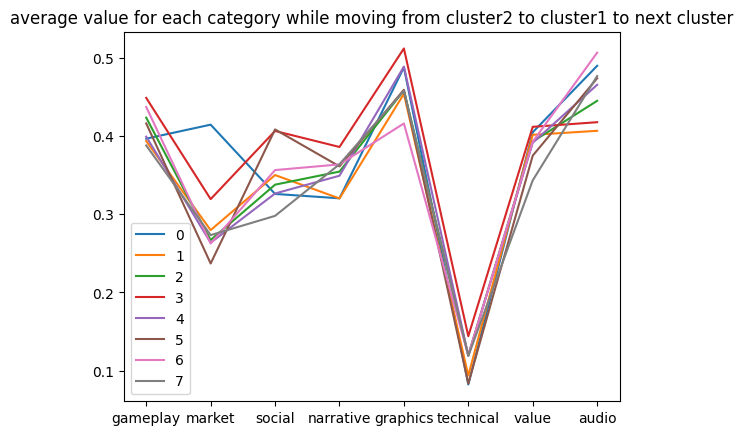

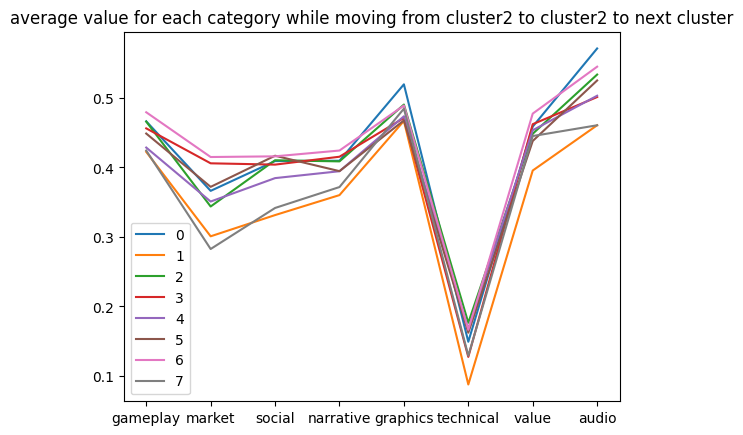

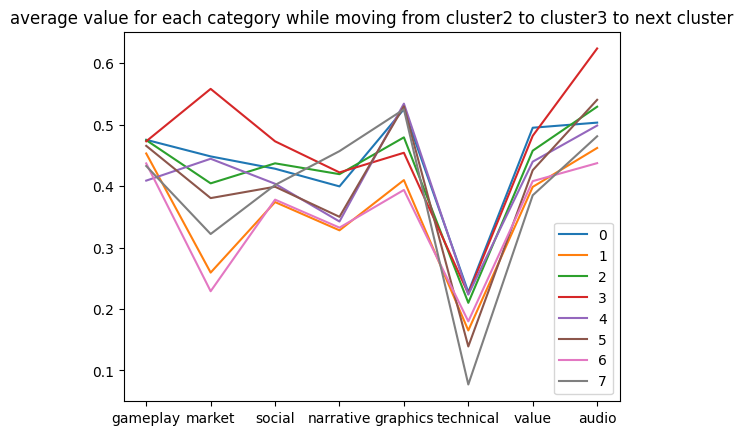

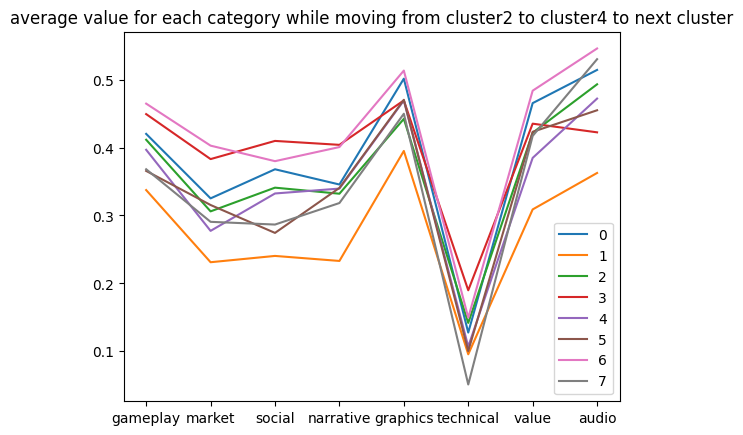

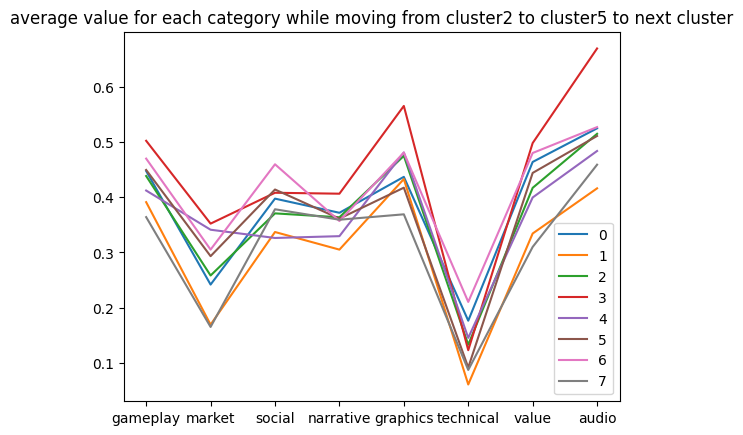

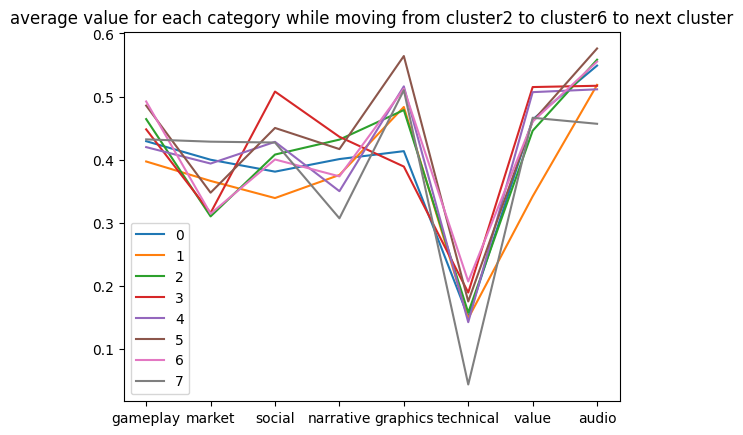

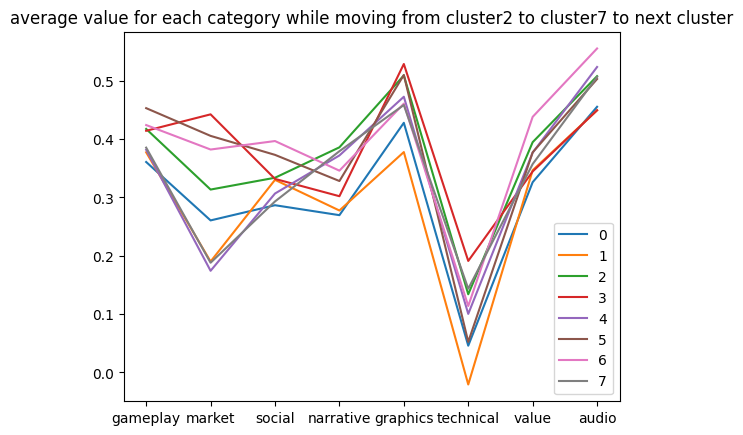

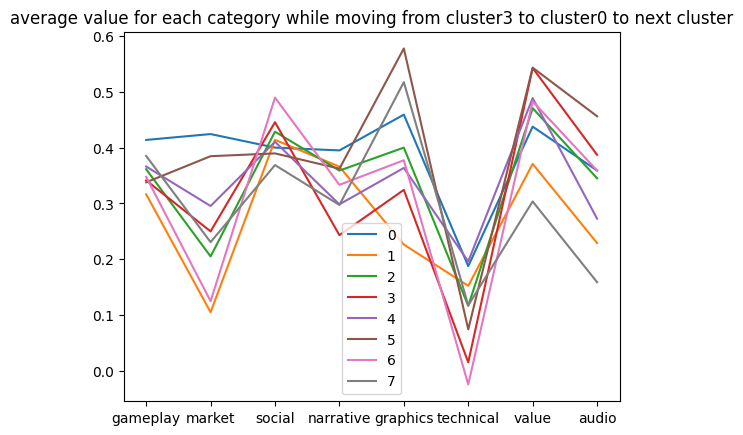

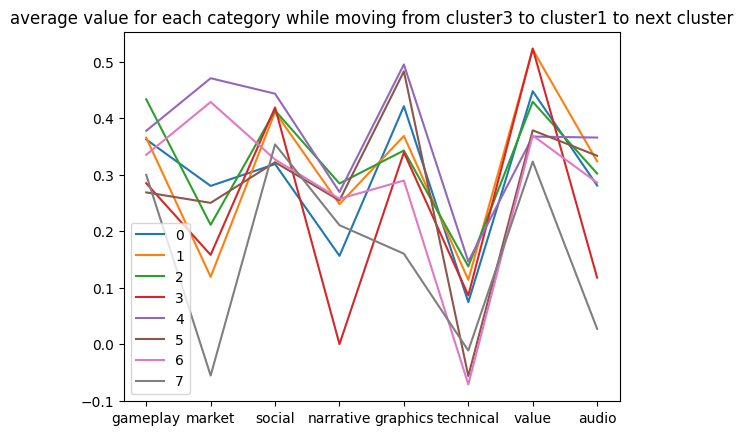

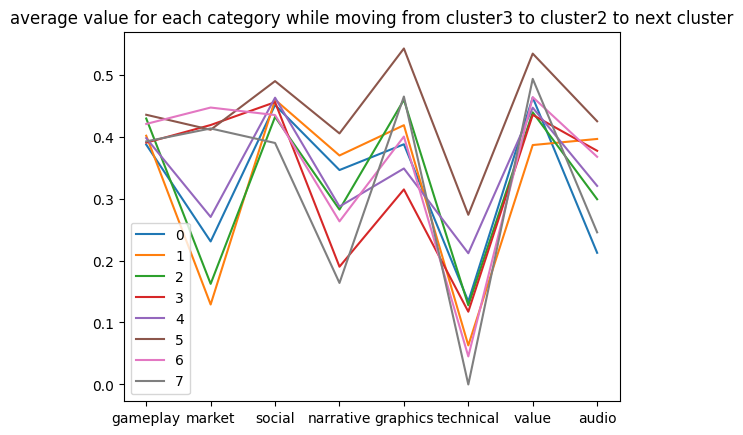

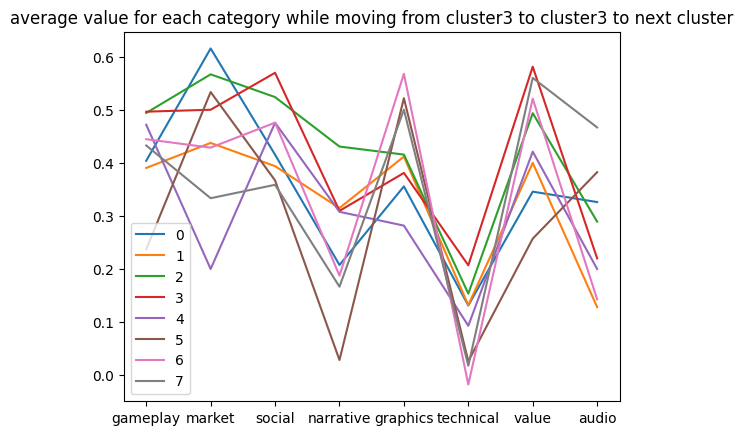

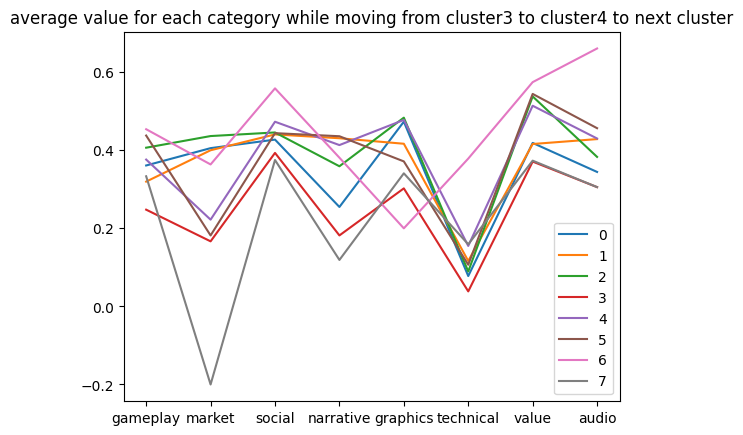

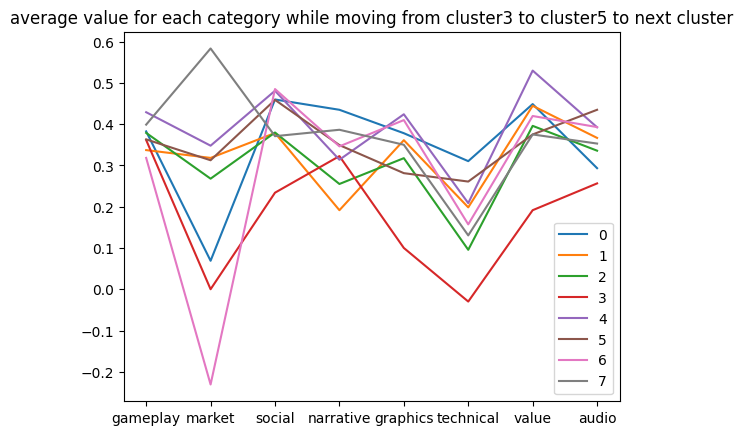

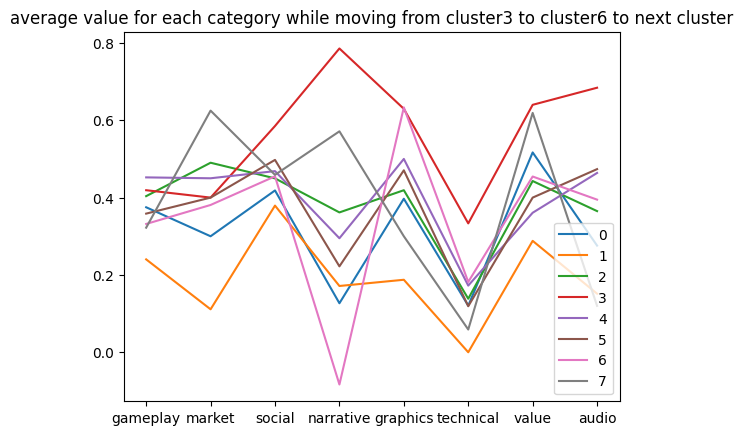

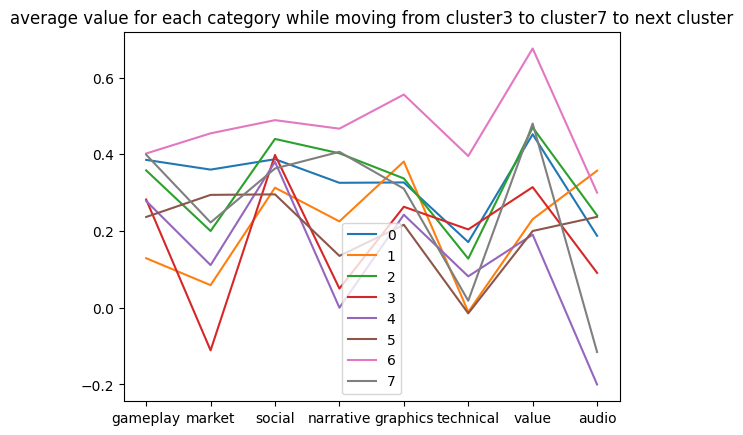

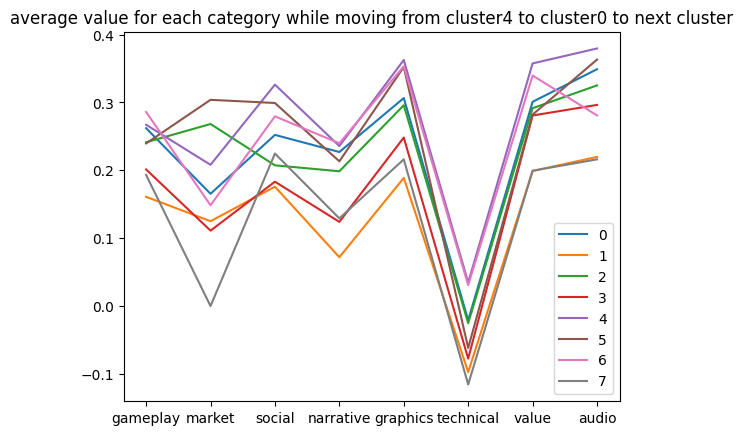

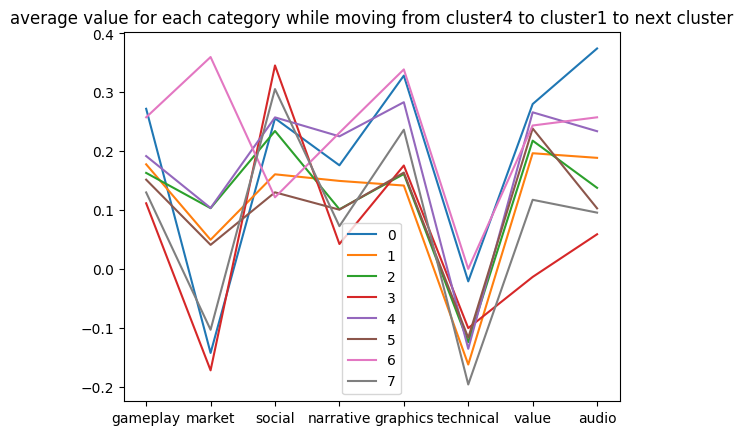

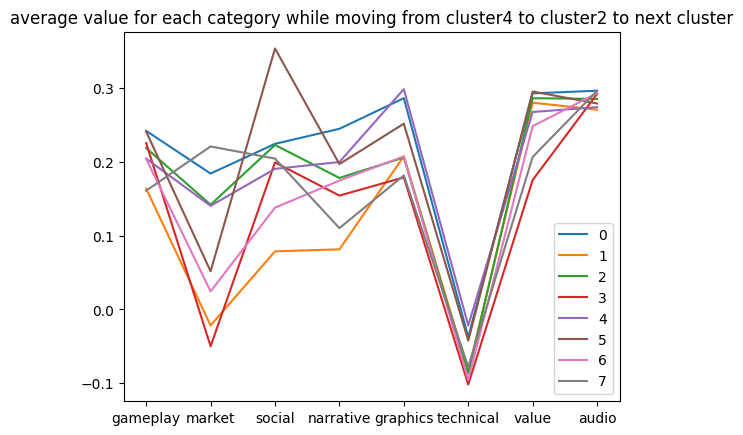

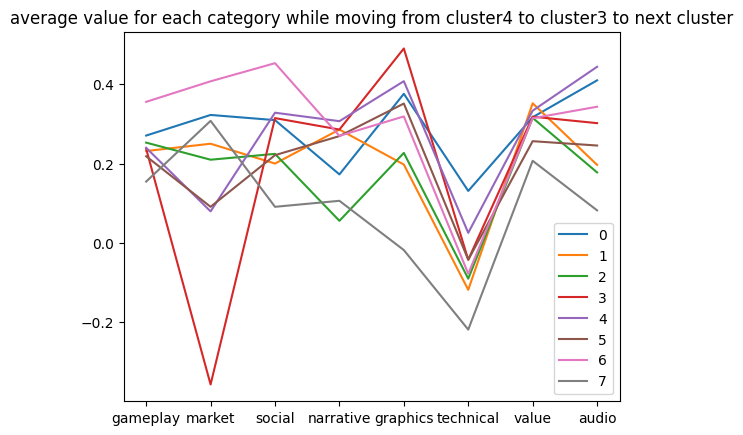

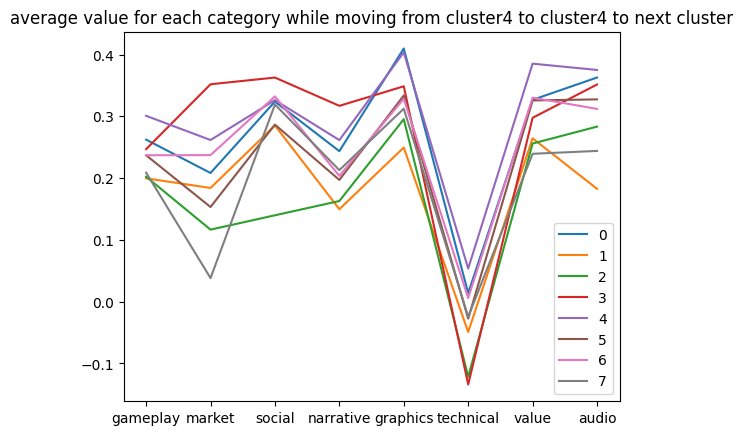

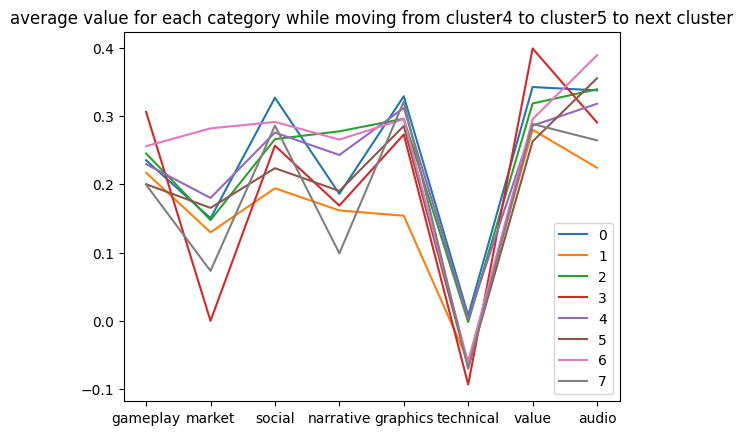

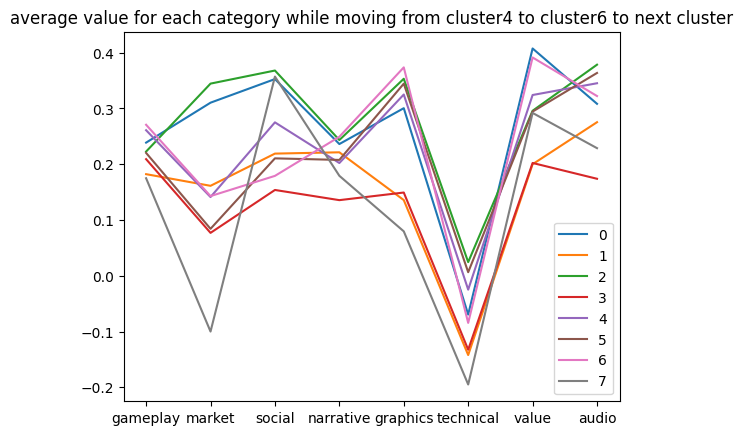

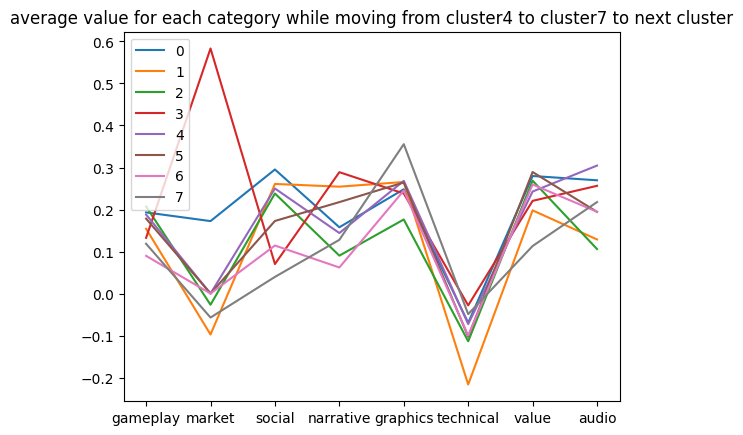

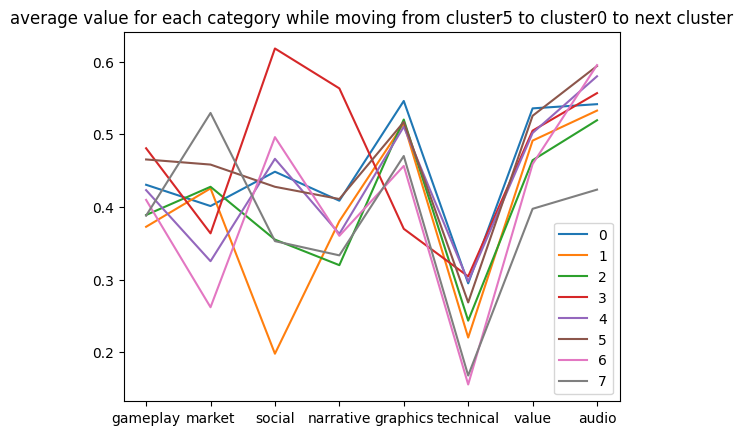

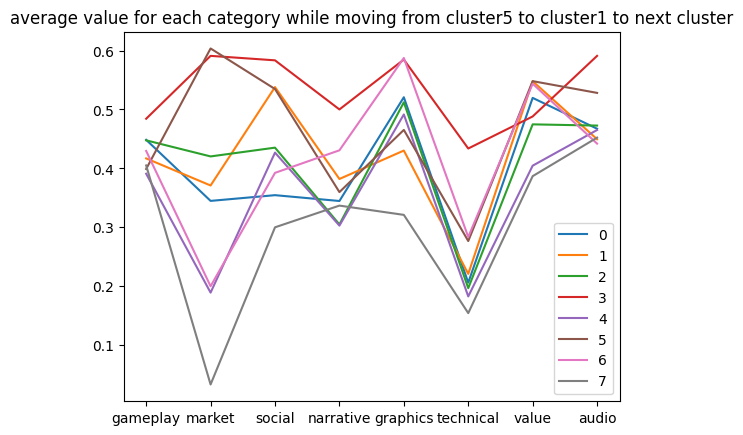

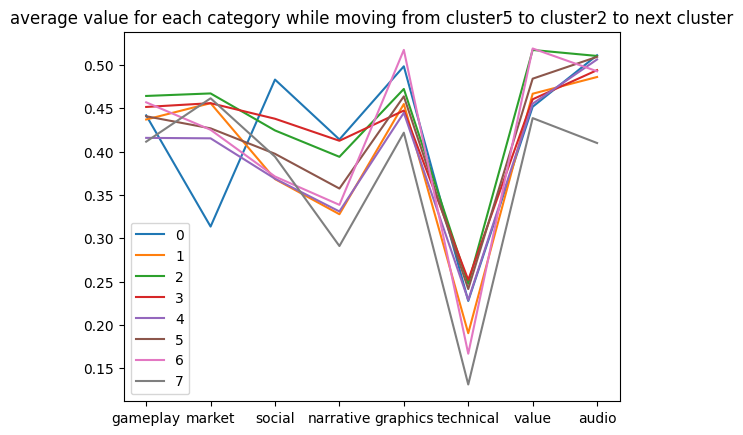

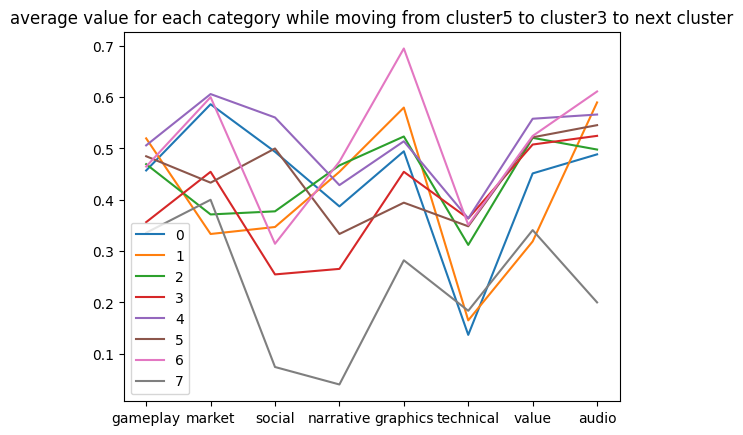

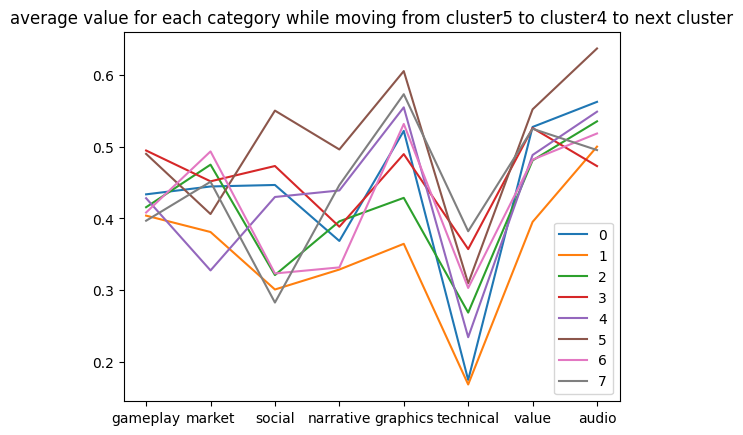

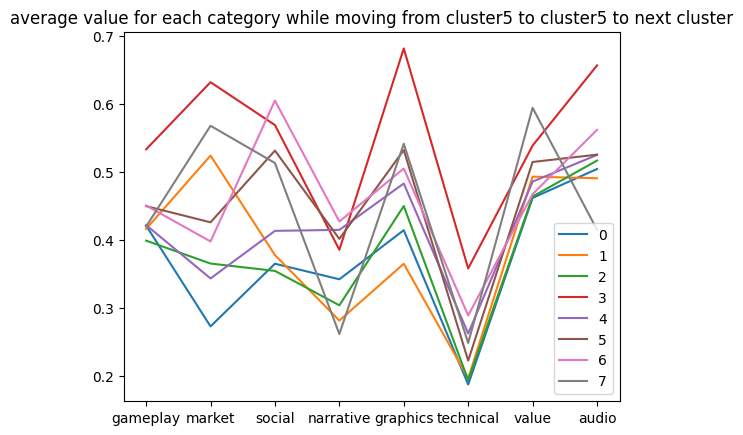

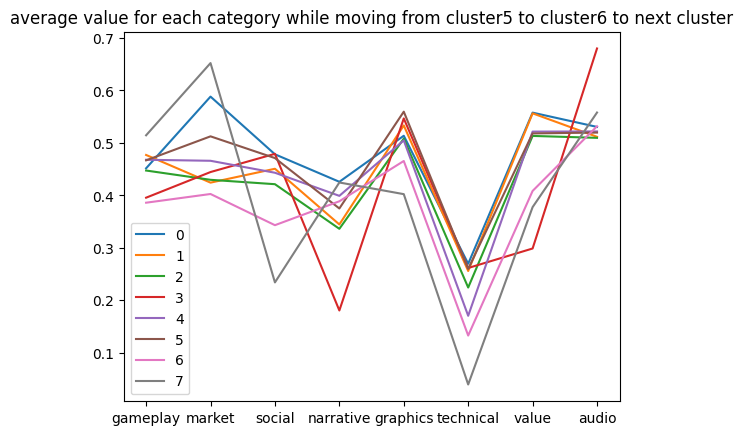

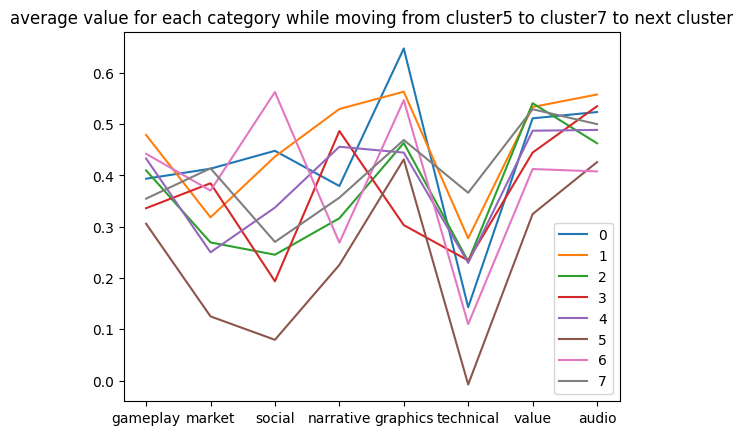

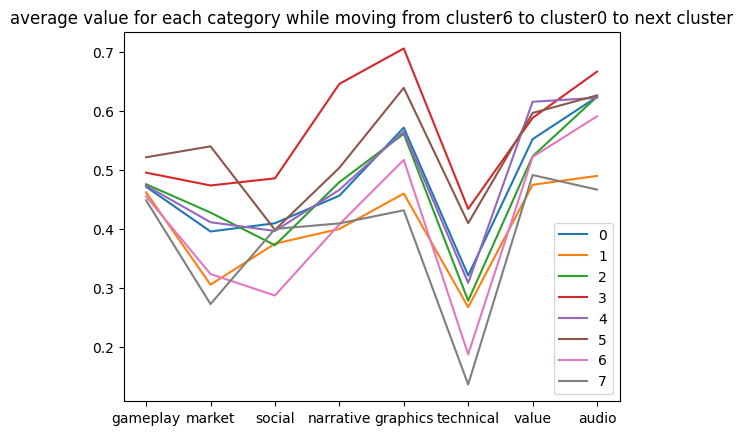

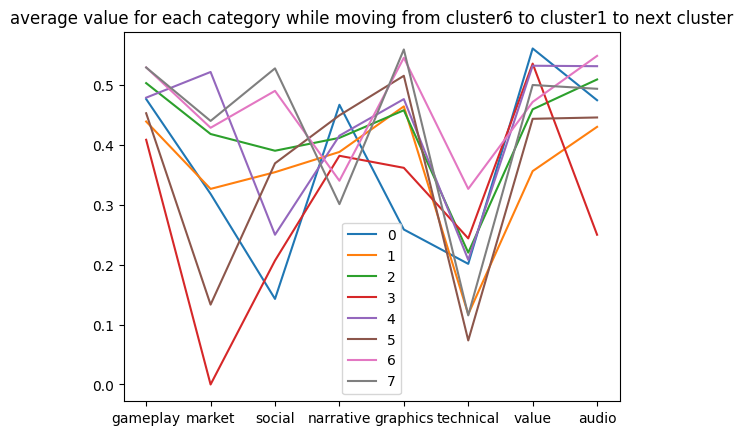

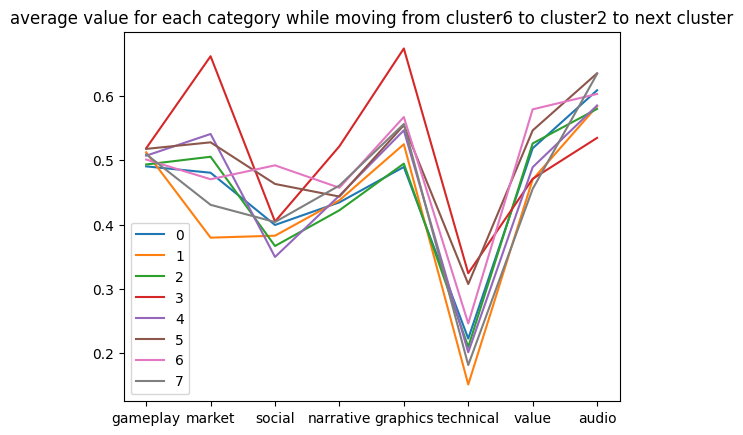

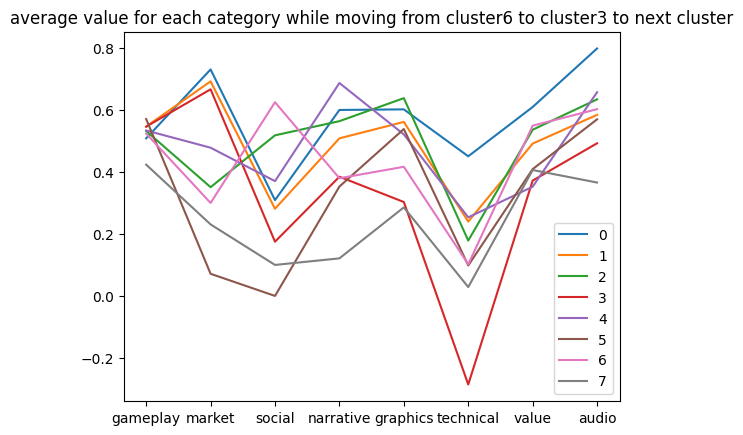

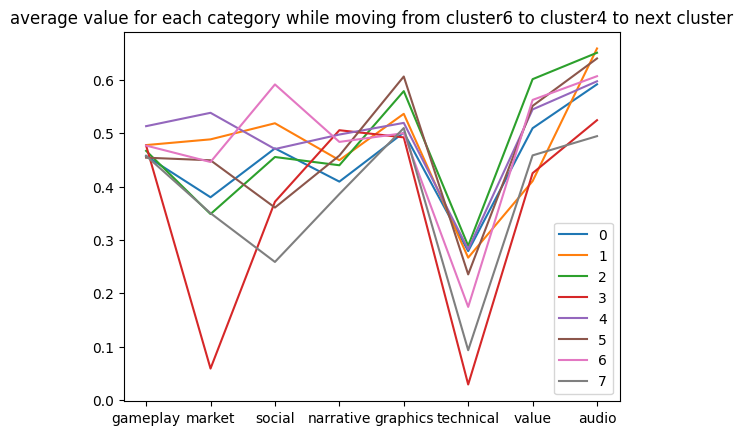

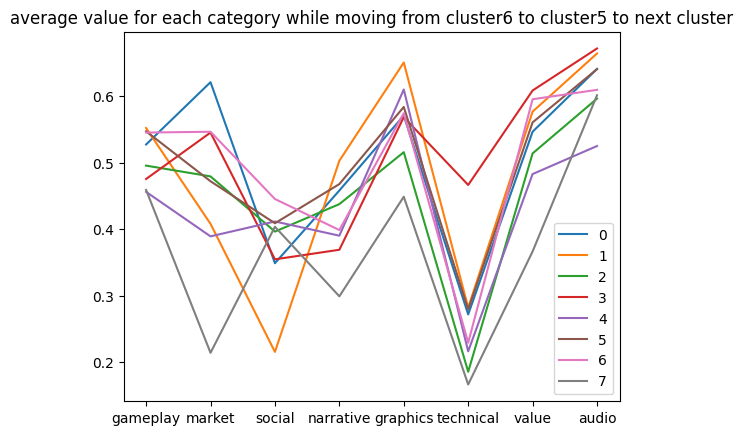

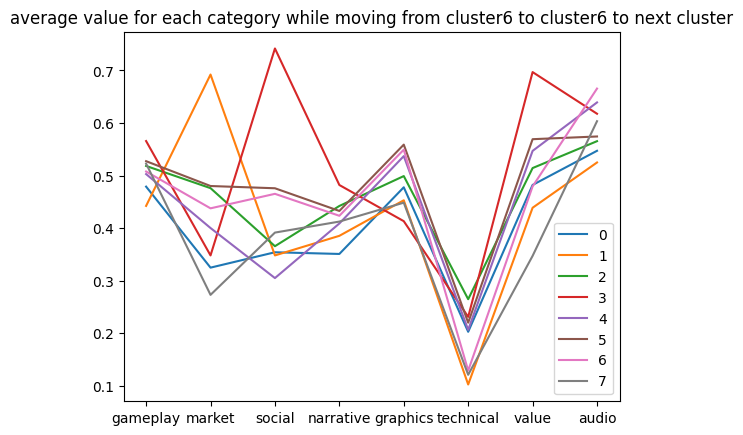

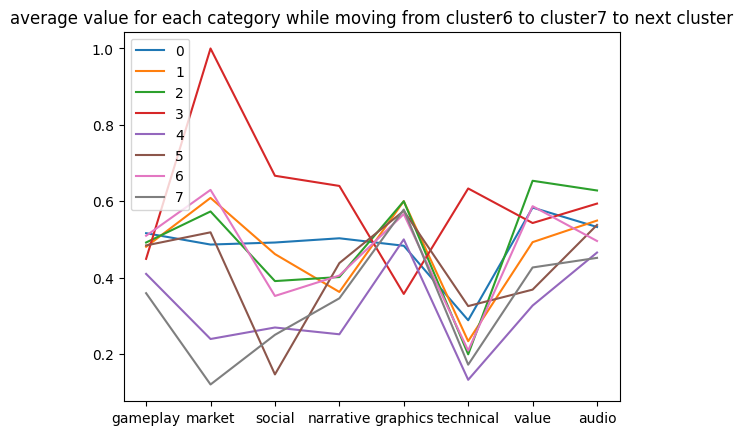

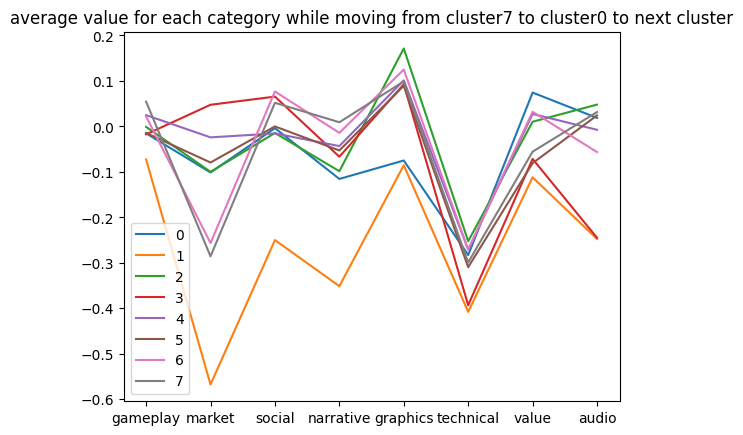

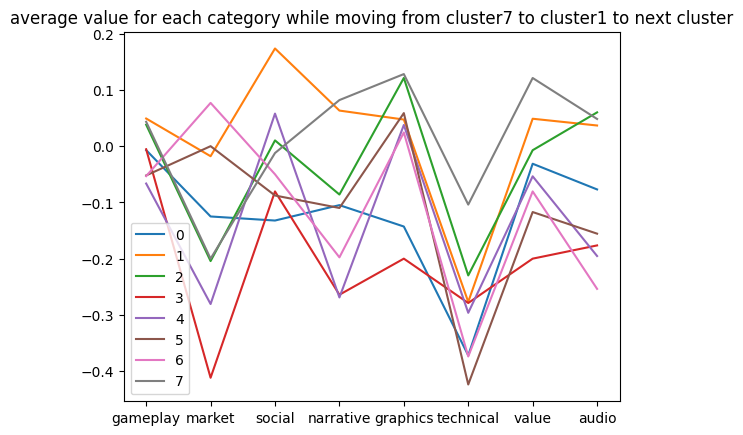

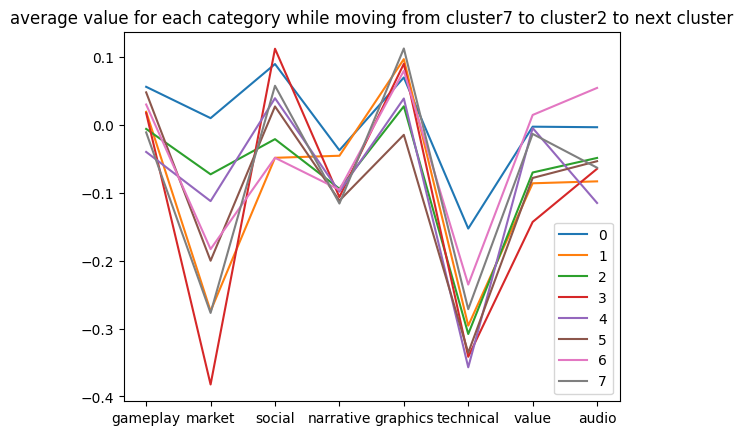

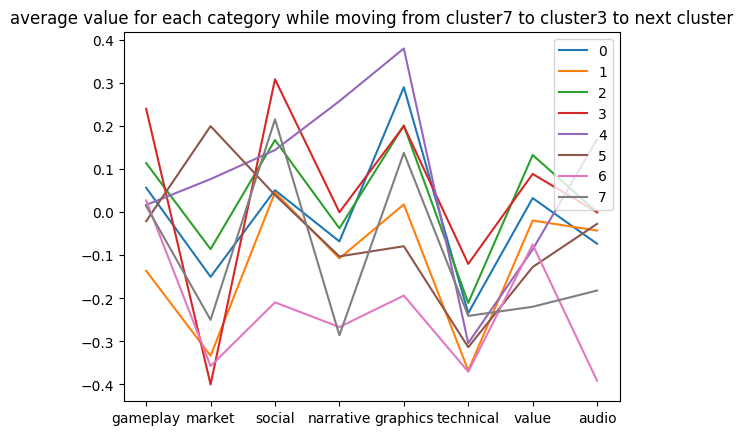

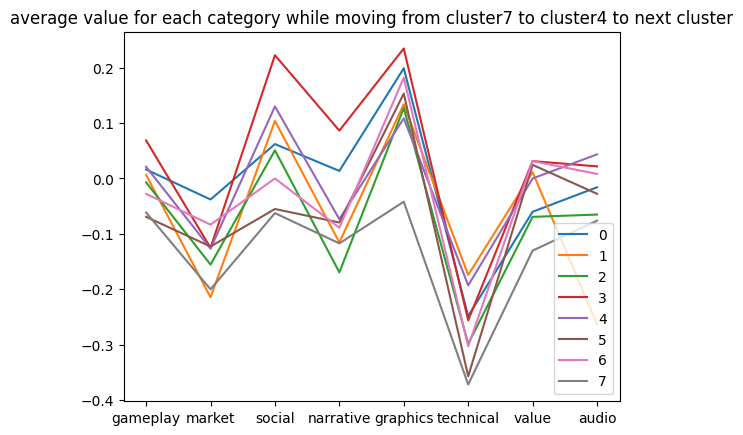

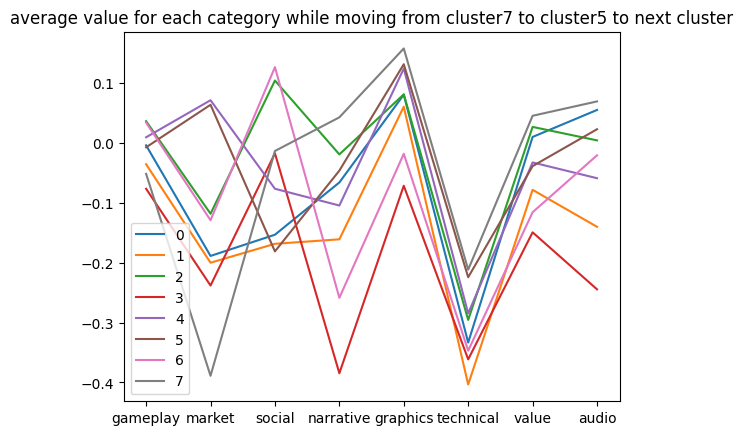

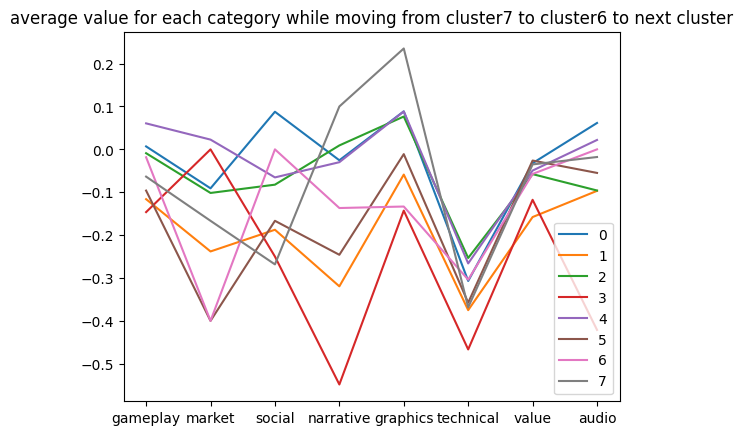

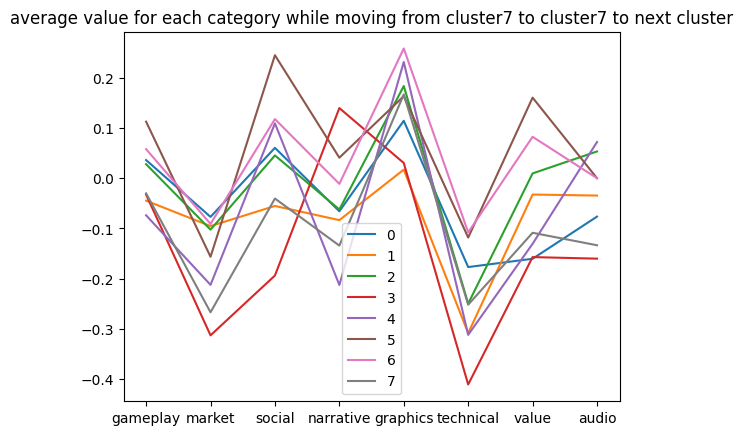

In [ ]:
#two step 보기
import matplotlib.pyplot as plt
for i in range(8):
    for j in range(8):
        for k in range(8):
            plt.plot(['gameplay','market','social','narrative','graphics','technical','value','audio'], two_step[i][j][k], label = k)
        plt.legend()
        plt.title(f"average value for each category while moving from cluster{i} to cluster{j} to next cluster")
        plt.show()

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import display
import itertools
from collections import Counter
import json

In [ ]:
file_path = '/content/drive/MyDrive/DA-STEAM 게임시장분석/data/user_review_chain_0509.json'

# Load the JSON file
with open(file_path, 'r') as file:
    user_review_chain = json.load(file)
#user_review_chain

In [ ]:
df = pd.DataFrame(user_review_chain)
df = df.transpose()
df.columns = ['a','b','c','d','e','f','g']
df = df[['a','g']]
df.columns = ['chain','eval']

In [ ]:
df.head()

chain  \
76561197960265744           [2]   
76561197960265776     [2, 5, 6]   
76561197960265840  [2, 2, 0, 2]   
76561197960265936           [5]   
76561197960266032           [2]   

                                                                eval  
76561197960265744         [[nan, nan, nan, nan, nan, 0.0, nan, nan]]  
76561197960265776  [[nan, nan, nan, 2.0, nan, nan, 2.0, 2.0], [2....  
76561197960265840  [[nan, nan, 2.0, nan, nan, nan, nan, 2.0], [na...  
76561197960265936         [[2.0, nan, nan, nan, nan, nan, nan, nan]]  
76561197960266032         [[nan, nan, nan, nan, 0.0, 2.0, nan, nan]]

## 가장 최근 게임 분석

In [ ]:
df['last_elements'] = df['chain'].apply(lambda x: x[-1])

In [ ]:
df.head()

chain  \
76561197960265744           [2]   
76561197960265776     [2, 5, 6]   
76561197960265840  [2, 2, 0, 2]   
76561197960265936           [5]   
76561197960266032           [2]   

                                                                eval  \
76561197960265744         [[nan, nan, nan, nan, nan, 0.0, nan, nan]]   
76561197960265776  [[nan, nan, nan, 2.0, nan, nan, 2.0, 2.0], [2....   
76561197960265840  [[nan, nan, 2.0, nan, nan, nan, nan, 2.0], [na...   
76561197960265936         [[2.0, nan, nan, nan, nan, nan, nan, nan]]   
76561197960266032         [[nan, nan, nan, nan, 0.0, 2.0, nan, nan]]   

                   last_elements  
76561197960265744              2  
76561197960265776              6  
76561197960265840              2  
76561197960265936              5  
76561197960266032              2

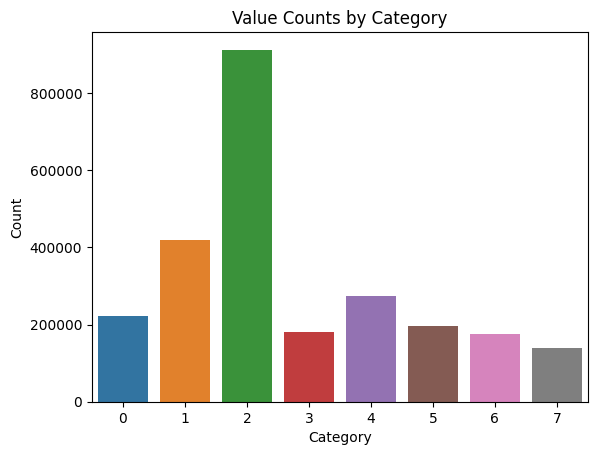

In [ ]:
import pandas as pd
import seaborn as sns
value_counts = df['last_elements'].value_counts()
# 막대 그래프 시각화
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts by Category')
plt.show()


## 같은 군집으로의 이동 시 유의미하게 작용한 요인 분석

2의 데이터가 가장 많아 예시로 2에서 2로의 요인 분석

In [ ]:
df_step2 = df.copy()

In [ ]:
def check_consecutive_twos(lst):
    for i in range(len(lst) - 1):
        if lst[i] == 2 and lst[i + 1] == 2:
            return True
    return False


In [ ]:
def apply_check_consecutive_twos(df, column_name):
    return df[column_name].apply(check_consecutive_twos)

In [ ]:
result = apply_check_consecutive_twos(df, 'chain')
df_step2['consecutive_two'] = result


In [ ]:
df_step2 = df_step2[df_step2['consecutive_two'] == True]

In [ ]:
df_step2.head()

chain  \
76561197960265840  [2, 2, 0, 2]   
76561197960267200        [2, 2]   
76561197960267696        [2, 2]   
76561197960268240  [2, 2, 2, 2]   
76561197960268304        [2, 2]   

                                                                eval  \
76561197960265840  [[nan, nan, 2.0, nan, nan, nan, nan, 2.0], [na...   
76561197960267200  [[nan, nan, nan, nan, 2.0, nan, nan, nan], [2....   
76561197960267696  [[2.0, nan, nan, nan, nan, nan, 2.0, nan], [na...   
76561197960268240  [[2.0, nan, nan, nan, nan, nan, nan, nan], [na...   
76561197960268304  [[nan, nan, nan, nan, nan, nan, 0.0, nan], [0....   

                   last_elements  consecutive_two  
76561197960265840              2             True  
76561197960267200              2             True  
76561197960267696              2             True  
76561197960268240              2             True  
76561197960268304              2             True

In [ ]:
def what_aspcet(df):

  aspect = []

  for i in range(len(df)):
    for j in range(len(df['eval'][i])):
      for k in df['eval'][i][j]:
        aspect.append(k)
  return aspect

In [ ]:
results = what_aspcet(df_step2)

In [ ]:
rows = [results[i:i+8] for i in range(0, len(results), 8)]

# 데이터프레임 생성
consecutive_two = pd.DataFrame(rows)

In [ ]:
consecutive_two

0    1    2    3    4   5   6    7
0        NaN  NaN  2.0  NaN  NaN NaN NaN  2.0
1        NaN  2.0  NaN  NaN  NaN NaN NaN  NaN
2        2.0  NaN  NaN  NaN  NaN NaN NaN  NaN
3        2.0  NaN  NaN  NaN  NaN NaN NaN  NaN
4        NaN  NaN  NaN  NaN  2.0 NaN NaN  NaN
...      ...  ...  ...  ...  ...  ..  ..  ...
1215734  0.0  NaN  NaN  0.0  NaN NaN NaN  NaN
1215735  0.0  NaN  NaN  NaN  NaN NaN NaN  NaN
1215736  NaN  0.0  NaN  NaN  NaN NaN NaN  NaN
1215737  1.0  NaN  NaN  NaN  NaN NaN NaN  NaN
1215738  2.0  NaN  NaN  2.0  NaN NaN NaN  2.0

[1215739 rows x 8 columns]

긍정 평가(label 2) 개수 count

Cluster 2에서 Cluster 2로 갈 때, 0번째 Aspect(gameplay)의 영향이 가장 집계가 많이 된 것을 볼 수 있음.

In [ ]:
column_counts_positive = (consecutive_two == 2).sum()
print(column_counts_positive)


0    539336
1     42705
2    127106
3    174922
4    161807
5    148591
6    180664
7    172641
dtype: int64


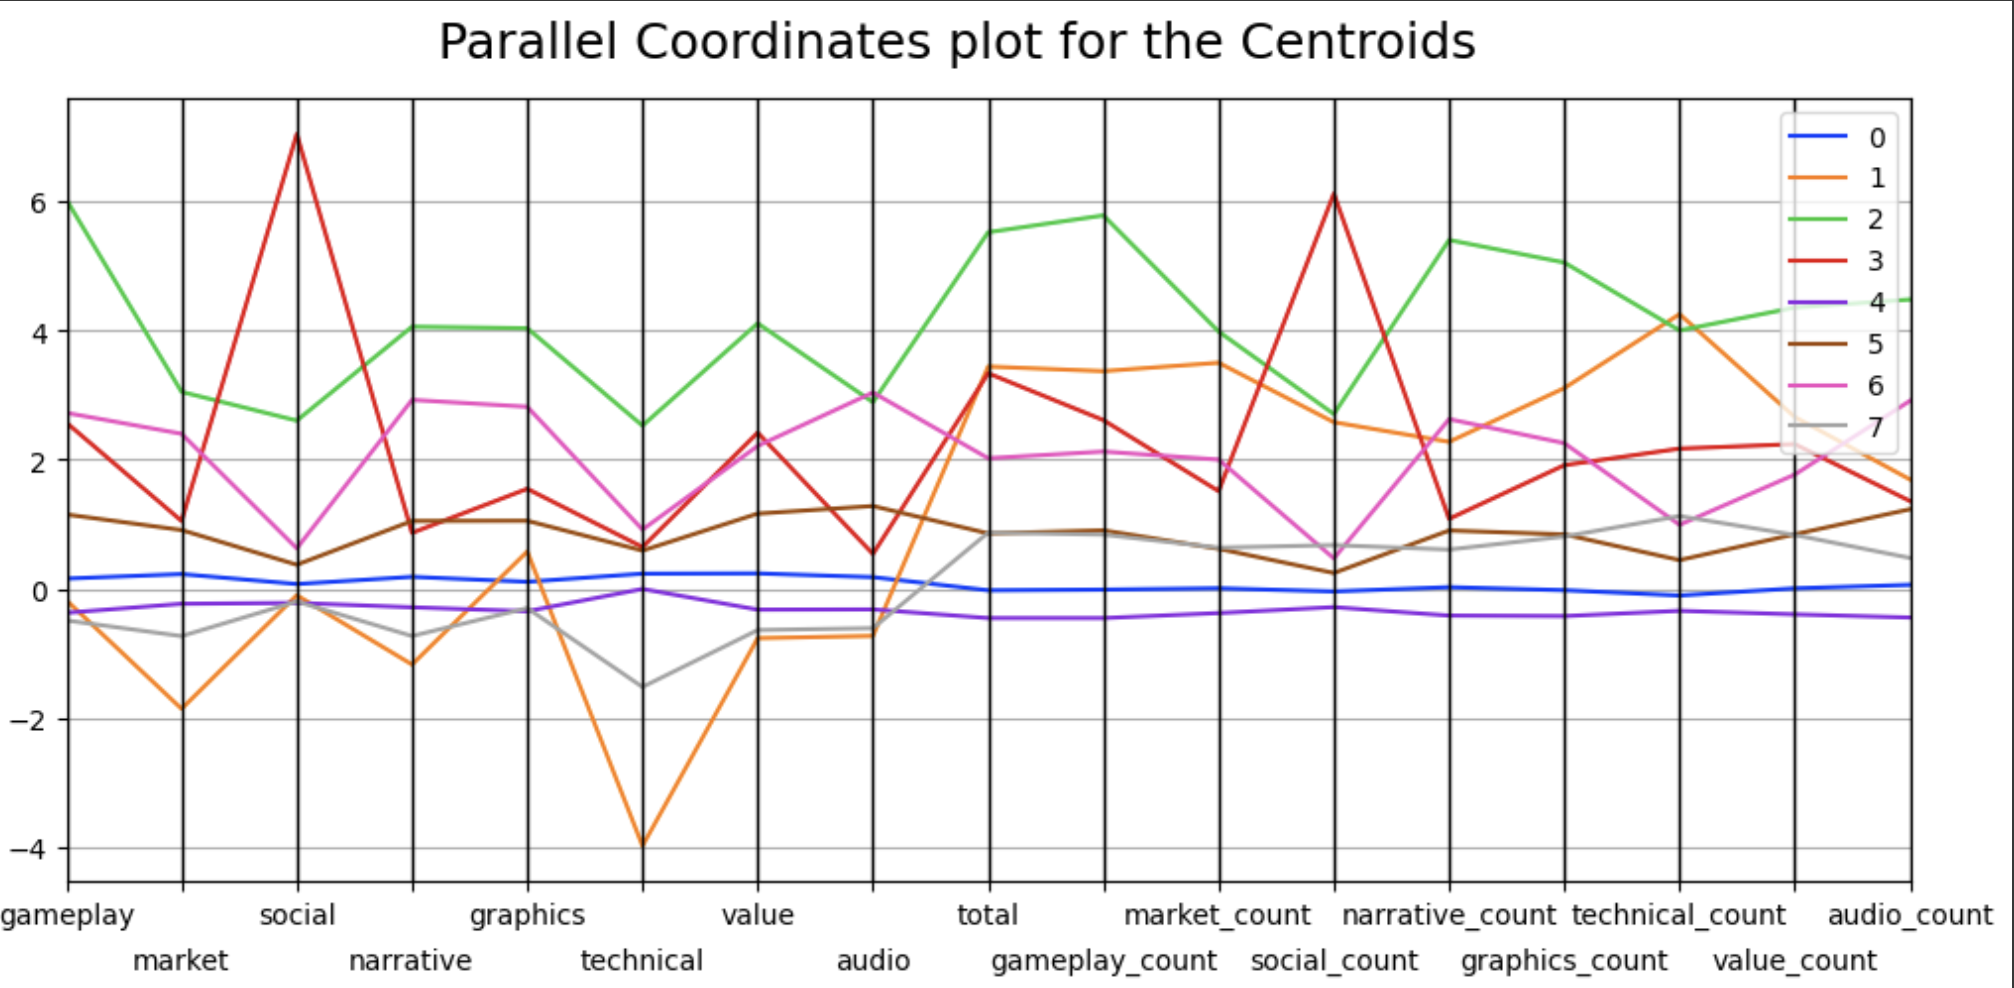

부정 대비 긍정 비율 확인

In [ ]:
column_counts_negative = (consecutive_two == 0).sum()
print(column_counts_negative)


0    254150
1     26542
2     63521
3     93846
4     68514
5    151095
6     87026
7     65577
dtype: int64


2에서 2로의 군집 이동 시, 특히 index 7 Aspect(audio)를 긍정적으로 평가한 것을 볼 수 있었음.

In [ ]:
column_counts_positive/column_counts_negative # 높을 수록 긍정비율이 높음

0    2.122117
1    1.608959
2    2.001008
3    1.863926
4    2.361663
5    0.983428
6    2.075977
7    2.632646
dtype: float64

## 다음 Cluster 분석

예를 들어, cluster 1에서 cluster 2로의 이동이 했을 때, 다음으로는 어떤 클러스터로의 이동이 많은지를 분석해보았다.

In [ ]:
df_step3 = df.copy()

In [ ]:
#df_step3.to_csv('/content/drive/MyDrive/DA-STEAM 게임시장분석/유찬/df_step3.csv', index = False)
df_step3 = pd.read_csv('/content/drive/MyDrive/DA-STEAM 게임시장분석/유찬/df_step3.csv')

In [ ]:
def check_string(string, number):
    target_string = f'1, 2, {number}'
    return target_string in string
    
def check(string):
    target_string = '1, 2'
    return target_string in string


In [ ]:
df_step3['1,2'] = df_step3['chain'].apply(check)

In [ ]:
for i in range(8):  # Loop from 0 to 7
    df_step3[f'1,2,{i}'] = df_step3['chain'].apply(lambda x: check_string(x, i))


In [ ]:
df_step3.head()

chain                                               eval  \
0           [2]         [[nan, nan, nan, nan, nan, 0.0, nan, nan]]   
1     [2, 5, 6]  [[nan, nan, nan, 2.0, nan, nan, 2.0, 2.0], [2....   
2  [2, 2, 0, 2]  [[nan, nan, 2.0, nan, nan, nan, nan, 2.0], [na...   
3           [5]         [[2.0, nan, nan, nan, nan, nan, nan, nan]]   
4           [2]         [[nan, nan, nan, nan, 0.0, 2.0, nan, nan]]   

   last_elements    1,2  1,2,0  1,2,1  1,2,2  1,2,3  1,2,4  1,2,5  1,2,6  \
0              2  False  False  False  False  False  False  False  False   
1              6  False  False  False  False  False  False  False  False   
2              2  False  False  False  False  False  False  False  False   
3              5  False  False  False  False  False  False  False  False   
4              2  False  False  False  False  False  False  False  False   

   1,2,7  
0  False  
1  False  
2  False  
3  False  
4  False

In [ ]:
print("0" + " :" + " " + str(len(df_step3[df_step3['1,2,0'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("1" + " :" + " " + str(len(df_step3[df_step3['1,2,1'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("2" + " :" + " " + str(len(df_step3[df_step3['1,2,2'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("3" + " :" + " " + str(len(df_step3[df_step3['1,2,3'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("4" + " :" + " " + str(len(df_step3[df_step3['1,2,4'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("5" + " :" + " " + str(len(df_step3[df_step3['1,2,5'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("6" + " :" + " " + str(len(df_step3[df_step3['1,2,6'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 
print("7" + " :" + " " + str(len(df_step3[df_step3['1,2,7'] == True])/len(df_step3[df_step3['1,2'] == True]) * 100)) 


0 : 5.579801140457418
1 : 10.763324206929205
2 : 23.973279535582684
3 : 3.8897008872511685
4 : 6.792309117483583
5 : 5.433641435247134
6 : 4.553595322889433
7 : 4.13878996232785


## Cluster chain 연관분석

In [ ]:
df_step4 = df.copy()

In [ ]:
df_step4.head()

chain  \
76561197960265744           [2]   
76561197960265776     [2, 5, 6]   
76561197960265840  [2, 2, 0, 2]   
76561197960265936           [5]   
76561197960266032           [2]   

                                                                eval  \
76561197960265744         [[nan, nan, nan, nan, nan, 0.0, nan, nan]]   
76561197960265776  [[nan, nan, nan, 2.0, nan, nan, 2.0, 2.0], [2....   
76561197960265840  [[nan, nan, 2.0, nan, nan, nan, nan, 2.0], [na...   
76561197960265936         [[2.0, nan, nan, nan, nan, nan, nan, nan]]   
76561197960266032         [[nan, nan, nan, nan, 0.0, 2.0, nan, nan]]   

                   last_elements  
76561197960265744              2  
76561197960265776              6  
76561197960265840              2  
76561197960265936              5  
76561197960266032              2

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:

# encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(df_step4['chain']).transform(df_step4['chain'])

# convert the encoded data to a DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


In [ ]:
df_encoded

0      1      2      3      4      5      6      7
0        False  False   True  False  False  False  False  False
1        False  False   True  False  False   True   True  False
2         True  False   True  False  False  False  False  False
3        False  False  False  False  False   True  False  False
4        False  False   True  False  False  False  False  False
...        ...    ...    ...    ...    ...    ...    ...    ...
2521100  False  False   True  False  False  False  False  False
2521101  False  False   True  False  False  False  False  False
2521102  False  False   True  False  False  False  False  False
2521103  False  False   True  False  False  False  False  False
2521104   True   True   True  False   True   True   True   True

[2521105 rows x 8 columns]

In [ ]:
# Find frequent itemsets with a minimum support of 0.1
frequent_itemsets = apriori(df_encoded.iloc[:, :], min_support=0.05, use_colnames=True)

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.05)

# Include rules with identical antecedents and consequents
rules = rules.append(rules[rules['antecedents'] == rules['consequents']])

# Sort the rules by support in descending order
rules = rules.sort_values(by='support', ascending=False)

# Print the association rules
rules


antecedents consequents  antecedent support  consequent support   support  \
2         (1)         (2)            0.241445            0.490302  0.079213   
3         (2)         (1)            0.490302            0.241445  0.079213   
4         (2)         (4)            0.490302            0.159108  0.058868   
5         (4)         (2)            0.159108            0.490302  0.058868   
0         (0)         (2)            0.140510            0.490302  0.055767   
1         (2)         (0)            0.490302            0.140510  0.055767   
6         (2)         (5)            0.490302            0.127778  0.053469   
7         (5)         (2)            0.127778            0.490302  0.053469   

   confidence      lift  leverage  conviction  
2    0.328081  0.669139 -0.039168    0.758570  
3    0.161560  0.669139 -0.039168    0.904722  
4    0.120064  0.754607 -0.019143    0.955628  
5    0.369986  0.754607 -0.019143    0.809025  
0    0.396892  0.809484 -0.013125    0.845118  
1    0.113740  0.809484 -0.013125    0.969795  
6    0.109054  0.853466 -0.009180    0.978984  
7    0.418457  0.853466 -0.009180    0.876456

In [ ]:
'''
2. Confidence
- 앞서 선정한 items (많이 구매된 메뉴)을 사용하여 함께 구매된 items를 확인
- antecedents (조건절), consequents (결과절): Antecedents를 구매했을 때 consequents를 구매
'''
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1).sort_values(by = ['confidence', 'lift', 'support'], ascending=False) # 최소 confidence를 0.1로 지정

antecedents consequents  antecedent support  consequent support   support  \
7         (5)         (2)            0.127778            0.490302  0.053469   
0         (0)         (2)            0.140510            0.490302  0.055767   
5         (4)         (2)            0.159108            0.490302  0.058868   
2         (1)         (2)            0.241445            0.490302  0.079213   
3         (2)         (1)            0.490302            0.241445  0.079213   
4         (2)         (4)            0.490302            0.159108  0.058868   
1         (2)         (0)            0.490302            0.140510  0.055767   
6         (2)         (5)            0.490302            0.127778  0.053469   

   confidence      lift  leverage  conviction  
7    0.418457  0.853466 -0.009180    0.876456  
0    0.396892  0.809484 -0.013125    0.845118  
5    0.369986  0.754607 -0.019143    0.809025  
2    0.328081  0.669139 -0.039168    0.758570  
3    0.161560  0.669139 -0.039168    0.904722  
4    0.120064  0.754607 -0.019143    0.955628  
1    0.113740  0.809484 -0.013125    0.969795  
6    0.109054  0.853466 -0.009180    0.978984

In [ ]:
'''
3. Lift
- 1보다 클 경우 A를 샀을 때 B을 살 확률이 높아지는 것을 의미
- 1보다 작을 경우 A를 샀을 때 B을 사지 않을 확률이 높은 것을 의미  
'''
association_rules(frequent_itemsets, metric="lift", min_threshold=0.8).sort_values(by = [ 'lift', 'confidence', 'support'], ascending=False)

antecedents consequents  antecedent support  consequent support   support  \
3         (5)         (2)            0.127778            0.490302  0.053469   
2         (2)         (5)            0.490302            0.127778  0.053469   
0         (0)         (2)            0.140510            0.490302  0.055767   
1         (2)         (0)            0.490302            0.140510  0.055767   

   confidence      lift  leverage  conviction  
3    0.418457  0.853466 -0.009180    0.876456  
2    0.109054  0.853466 -0.009180    0.978984  
0    0.396892  0.809484 -0.013125    0.845118  
1    0.113740  0.809484 -0.013125    0.969795